In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode
import string
import spacy
from gensim.models import FastText
import random
import numpy as np
import umap
from sklearn.manifold import TSNE
import lightgbm as lgb
from sklearn.decomposition import PCA



In [26]:
df = pd.read_excel('Datos/Data_Traspaso_2.xlsx')

# Reseñas Online

In [27]:
df_resenas = pd.read_excel('Datos/Reseñas.xlsx')

In [28]:
df_resenas[df_resenas.duplicated(subset=['Reseña'], keep=False)]

,Centro Comercial,Estrellas,Reseña
1081,Mall Plaza Los Domínicos,5,Muy lindo
1381,Mall Independencia,5,Excelente
2596,Espacio Urbano Laguna Piedra Roja,5,Muy lindo
2704,Espacio Urbano La Dehesa,5,Muy lindo
2896,Mall Portal La Reina,5,Excelente


## Modelos NLP


### Fasttext

Limpieza para Fasttext

Se eliminan pasa todo a minúscula, se eliminan las tíldes, puntuación y las stopwords, y se tokenizan las reseñas. 

In [ ]:
# Lista de stop_words personalizada
stop_words = [
    'a', 'al', 'algo', 'ahora', 'ademas', 'algunas', 'algunos', 'ante', 'antes', 'asi','aun', 'aunque', 'ahi', 'cada', 'centro', 'comercial','como', 'con', 'contra', 'cual', 'cuando',
    'de', 'del', 'desde', 'donde','durante', 'e', 'el', 'ella', 'ellas', 'ellos', 'en', 'entre', 'era', 'erais',
    'eran', 'eras', 'eres', 'es', 'esa', 'esas', 'ese', 'eso', 'esos', 'esta','está', 'estaba', 'estabais', 'estaban',
    'estabas', 'estad', 'estada', 'estadas', 'estado', 'estados', 'estamos', 'estando', 'estar', 'estaremos', 'estará',
    'estarán', 'estarás', 'estaré', 'estaréis', 'estaría', 'estaríais', 'estaríamos', 'estarían', 'estarías', 'estas',
    'este', 'estemos', 'esto', 'estos', 'estoy', 'estuve', 'estuviera', 'estuvierais', 'estuvieran', 'estuvieras',
    'estuvieron', 'estuviese', 'estuvieseis', 'estuviesen', 'estuvieses', 'estuvimos', 'estuviste', 'estuvisteis',
    'estuvieramos', 'estuviesemos', 'estuvo', 'estan', 'estas', 'este', 'estéis', 'estén', 'estés', 'ex', 'excepto',
    'fue', 'fuera', 'fuerais', 'fueran', 'fueras', 'fueron', 'fuese', 'fueseis', 'fuesen', 'fueses', 'fui', 'fuimos',
    'fuiste', 'fuisteis', 'fuéramos', 'fuésemos', 'ha', 'habida', 'habidas', 'habido', 'habidos', 'habiendo', 'habremos',
    'habrá', 'habrán', 'habrás', 'habré', 'habréis', 'habría', 'habríais', 'habríamos', 'habrían', 'habrías', 'habéis',
    'había', 'habíais', 'habíamos', 'habían', 'habías', 'han', 'has', 'hasta', 'hay', 'haya', 'hayamos', 'hayan',
    'hayas', 'hayáis', 'he', 'hemos', 'hube', 'hubiera', 'hubierais', 'hubieran', 'hubieras', 'hubieron', 'hubiese',
    'hubieseis', 'hubiesen', 'hubieses', 'hubimos', 'hubiste', 'hubisteis', 'hubiéramos', 'hubiésemos', 'hubo', 'ir',
    'la', 'las', 'le', 'les', 'lo', 'los', 'me', 'mi', 'mis', 'mucho', 'muchos', 'muy', 'mas', 'mí', 'mía', 'mías',
    'mio', 'mios', 'nada', 'ni', 'nos', 'nosotras', 'nosotros', 'nuestra', 'nuestras', 'nuestro', 'nuestros',
    'nunca', 'os', 'otra', 'otras', 'otro', 'otros', 'pues' , 'para', 'pero', 'poco', 'por', 'porque', 'que', 'quien', 'quienes',
    'qué', 'se', 'sea', 'seamos', 'sean', 'seas', 'seremos', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria',
    'seriais', 'seriamos', 'ser', 'serían', 'serías', 'seáis', 'sido', 'siendo', 'sin', 'sobre', 'sois', 'solamente', 'solo', #Saqué ser, tiene sentido?
    'somos', 'son', 'soy', 'su', 'sus', 'suya', 'suyas', 'suyo', 'suyos', 'si', 'tambien', 'tanto', 'te',
    'tendremos', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos',
    'tendrían', 'tendrias', 'tened', 'tenemos', 'tenga', 'tengamos', 'tengan', 'tengas', 'tengo', 'tengáis',
    'tenida', 'tenidas', 'tenido', 'tenidos', 'teniendo', 'tenéis', 'tenía', 'teníais', 'teníamos', 'tenían','tenías',
    'ti', 'tiene', 'tienen', 'tienes', 'todo', 'todos', 'tu', 'tus', 'tuve', 'tuviera', 'tuvierais', 'tuvieran',
    'tuvieras', 'tuvieron', 'tuviese', 'tuvieseis', 'tuviesen', 'tuvieses', 'tuvimos', 'tuviste', 'tuvisteis',
    'tuviéramos', 'tuviésemos', 'tuvo', 'tuya', 'tuyas', 'tuyo', 'tuyos', 'tu', 'un', 'una', 'uno', 'unos',
    'vosotras', 'vosotros', 'vuestra', 'vuestras', 'vuestro', 'vuestros', 'y', 'ya', 'yo', 'él', 'éramos', 'mall',
    'tienda', 'tiendas'
]

# Cargar el modelo de spaCy en español
nlp = spacy.load('es_core_news_sm')

# Función de limpieza para eliminar stop_words personalizadas
#def Limpieza_texto(texto, stop_words):
 #   doc = nlp(texto)
  #  palabras_limpias = [token.lemma_ for token in doc if token.lemma_ not in stop_words and len(token.lemma_) > 1] #Tiene lematización
   # return ' '.join(palabras_limpias)

def Limpieza_texto(texto, stop_words):
    # Procesar el texto con spaCy
    doc = nlp(texto)
    # Filtrar palabras eliminando las stop words y las palabras de longitud 1 o menor
    palabras_limpias = [token.text for token in doc if token.text.lower() not in stop_words and len(token.text) > 1]
    return ' '.join(palabras_limpias)

# Ejemplo: Aplicar la función a un DataFrame (df_resenas)
df_resenas['reseña_limpia'] = df_resenas['Reseña_lematizada'].apply(lambda x: x.lower())  # Minúsculas
df_resenas['reseña_limpia'] = df_resenas['reseña_limpia'].apply(lambda x: unidecode(x))  # Eliminar tildes
df_resenas['reseña_limpia'] = df_resenas['reseña_limpia'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))  # Eliminar puntuación
df_resenas['reseña_limpia'] = df_resenas['reseña_limpia'].apply(lambda x: Limpieza_texto(x, stop_words))  # Eliminar stop_words


In [ ]:
# Tokenización para FastText (dividir en listas de palabras)
sentences = df_resenas['reseña_limpia'].apply(lambda x: x.split()).tolist()

In [ ]:
# Establecer semillas para reproducibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Entrenamiento SkipGram
ft_model = FastText(
    sentences=sentences,
    sg=1,
    window=5,
    min_count=2,
    workers=4,
    epochs=10,
    min_n=3,
    max_n=6
)

Vectores para cada reseña

In [ ]:
# Función para obtener el vector promedio de una reseña
def obtener_vector_resena(resena, model):
    palabras = resena.split()
    word_vectors = [model.wv[word] for word in palabras if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # Vector cero si no hay palabras conocidas

# Aplicar la función a cada reseña y crear una nueva columna 'vector_resena'
df_resenas['vector_resena'] = df_resenas['reseña_limpia'].apply(lambda x: obtener_vector_resena(x, ft_model))

# Mostrar las primeras filas del DataFrame con la nueva columna
df_resenas.head()


,Centro Comercial,Estrellas,Reseña,Reseña_lematizada,reseña_limpia,vector_resena
0,Plazuela Independencia,4,Para ser muy pequeño está bastante bueno Si ti...,Para ser muy pequeño estar bastante bueno Si t...,pequeno bastante bueno tienebez ganas comer jo...,"[-0.10587747, 0.30694583, -0.023218919, 0.2185..."
1,Plazuela Independencia,5,"Buen lugar limpio, ordenado y seguro. Sus esta...","Buena lugar limpio, ordenar y seguridad. Su es...",buena lugar limpio ordenar seguridad estaciona...,"[-0.19701284, 0.54492897, 0.05398948, 0.296642..."
2,Plazuela Independencia,3,Es difícil conseguir estacionamiento para movi...,Es difícil conseguir estacionamiento para movi...,dificil conseguir estacionamiento movilidad re...,"[-0.075229436, 0.21926603, 0.029064562, 0.2344..."
3,Plazuela Independencia,3,Un lugar donde puedes encontrar lo que quieras...,"Un lugar donde puedas encontrar lo quieres, pu...",lugar puedas encontrar quieres punto comercio ...,"[-0.17015497, 0.3792239, -0.024891796, 0.20380..."
4,Plazuela Independencia,3,"Tienes desde cine hasta supermercado, muy comp...","Tenés desde cine a supermercado, mucho complet...",tenes cine supermercado completo pequeno mal e...,"[-0.1696427, 0.36004055, -0.0012916981, 0.2719..."


In [ ]:
def ponderar_reseña(estrellas):
    if estrellas in [1, 2]:
        return 2  # Mayor peso
    else:
        return 1  # Menor peso

# Aplicar ponderaciones
df_resenas['ponderacion'] = df_resenas['Estrellas'].apply(ponderar_reseña)

vector para cada centro comercial

In [ ]:
# Función para calcular el promedio ponderado
def promedio_ponderado(vectores, ponderaciones):
    ponderaciones = np.array(ponderaciones)
    vectores = np.array(vectores)
    ponderaciones = ponderaciones / ponderaciones.sum()  # Normalizar las ponderaciones
    return np.average(vectores, axis=0, weights=ponderaciones)

# Agrupar por 'Centro Comercial' y calcular el promedio de vectores (no ponderado)
vectores_promedio = df_resenas.groupby('Centro Comercial')['vector_resena'].apply(
    lambda x: np.mean(np.array(x.tolist()), axis=0)
).reset_index()
vectores_promedio.columns = ['Centro Comercial', 'vector_promedio']

# Agrupar por 'Centro Comercial' y calcular el promedio ponderado de vectores
vectores_ponderados = df_resenas.groupby('Centro Comercial').apply(
    lambda x: promedio_ponderado(x['vector_resena'].tolist(), x['ponderacion'].tolist())
).reset_index()
vectores_ponderados.columns = ['Centro Comercial', 'vector_ponderado']

# Unir ambos DataFrames
resultados_fttx = pd.merge(vectores_promedio, vectores_ponderados, on='Centro Comercial')


/tmp/ipykernel_18732/2454876064.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vectores_ponderados = df_resenas.groupby('Centro Comercial').apply(


In [ ]:
resultados_fttx

,Centro Comercial,vector_promedio,vector_ponderado
0,Alto Las Condes,"[-0.119313106, 0.3500679, 0.0047205323, 0.2694...","[-0.11876309179286985, 0.3438320108861836, 0.0..."
1,Apumanque,"[-0.11217513, 0.34797174, -0.0034767657, 0.259...","[-0.11171254187467562, 0.3437358830656325, -0...."
2,Arauco Estación,"[-0.10390691, 0.34513456, 0.006201314, 0.24706...","[-0.10142986635151117, 0.3330993735919827, 0.0..."
3,Casa Costanera,"[-0.11115126, 0.39771953, -0.04774927, 0.23084...","[-0.10845383252118432, 0.38409630759902635, -0..."
4,Costanera Center,"[-0.12014571, 0.34399047, -0.0037218714, 0.266...","[-0.11675843923338737, 0.333010616639386, -0.0..."
5,Espacio Urbano Gran Avenida,"[-0.11296767401508986, 0.37202875681221487, 0....","[-0.11353597827429807, 0.3674041970728714, 0.0..."
6,Espacio Urbano La Dehesa,"[-0.10720654, 0.38509366, -0.0010271982, 0.280...","[-0.10725458008513816, 0.38373950802453705, -0..."
7,Espacio Urbano Laguna Piedra Roja,"[-0.10721557, 0.3491426, 0.010154662, 0.332866...","[-0.1068975175205874, 0.3476253330853641, 0.01..."
8,Espacio Urbano Puente Alto,"[-0.11731534, 0.39188167, -0.011511444, 0.2666...","[-0.11032101395116607, 0.3740148267962716, -0...."
9,Mall Arauco Maipú,"[-0.10809776, 0.35633343, 0.0012484518, 0.2766...","[-0.10585212615680777, 0.3476497152889215, 0.0..."


#### Gráfico Correlación

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extraer las dimensiones de los vectores promedio en columnas separadas
dimensiones_fttx_prom = pd.DataFrame(resultados_fttx['vector_promedio'].to_list(), index=resultados_fttx.index)

# Asignar nombres a las columnas de las dimensiones, por ejemplo: 'dim_1', 'dim_2', ..., 'dim_n'
dimensiones_fttx_prom.columns = [f'dim_{i+1}' for i in range(dimensiones_fttx_prom.shape[1])]

# Calcular la matriz de correlación para dimensiones promedio
correlation_matrix_prom = dimensiones_fttx_prom.corr()

# Filtrar la matriz de correlación para mostrar solo las correlaciones entre dimensiones
# Para mostrar solo las correlaciones significativas, puedes aplicar un umbral, por ejemplo 0.6
threshold = 0.7
correlation_matrix_filtered = correlation_matrix_prom[
    (correlation_matrix_prom.abs() > threshold) & (correlation_matrix_prom != 1)
]

# Mostrar la matriz de correlación entre dimensiones promedio
print("Correlación entre dimensiones promedio:")
correlation_matrix_filtered


Correlación entre dimensiones promedio:


,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,...,dim_91,dim_92,dim_93,dim_94,dim_95,dim_96,dim_97,dim_98,dim_99,dim_100
dim_1,NaN,-0.712833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.836451,NaN,NaN,NaN,NaN
dim_2,-0.712833,NaN,NaN,NaN,NaN,NaN,0.947691,NaN,0.898591,NaN,...,NaN,NaN,0.727316,NaN,NaN,0.734721,NaN,NaN,NaN,NaN
dim_3,NaN,NaN,NaN,NaN,0.880609,NaN,NaN,-0.847951,NaN,0.715731,...,NaN,NaN,NaN,-0.773572,NaN,NaN,NaN,NaN,-0.848299,-0.800009
dim_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dim_5,NaN,NaN,0.880609,NaN,NaN,NaN,NaN,-0.831847,NaN,NaN,...,NaN,NaN,NaN,-0.817311,NaN,NaN,NaN,NaN,NaN,-0.818815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dim_96,-0.836451,0.734721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dim_97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.775418,NaN,NaN
dim_98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.774310,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.775418,NaN,NaN,NaN
dim_99,NaN,NaN,-0.848299,NaN,NaN,NaN,NaN,0.732192,NaN,-0.725382,...,NaN,NaN,-0.741864,NaN,NaN,NaN,NaN,NaN,NaN,NaN


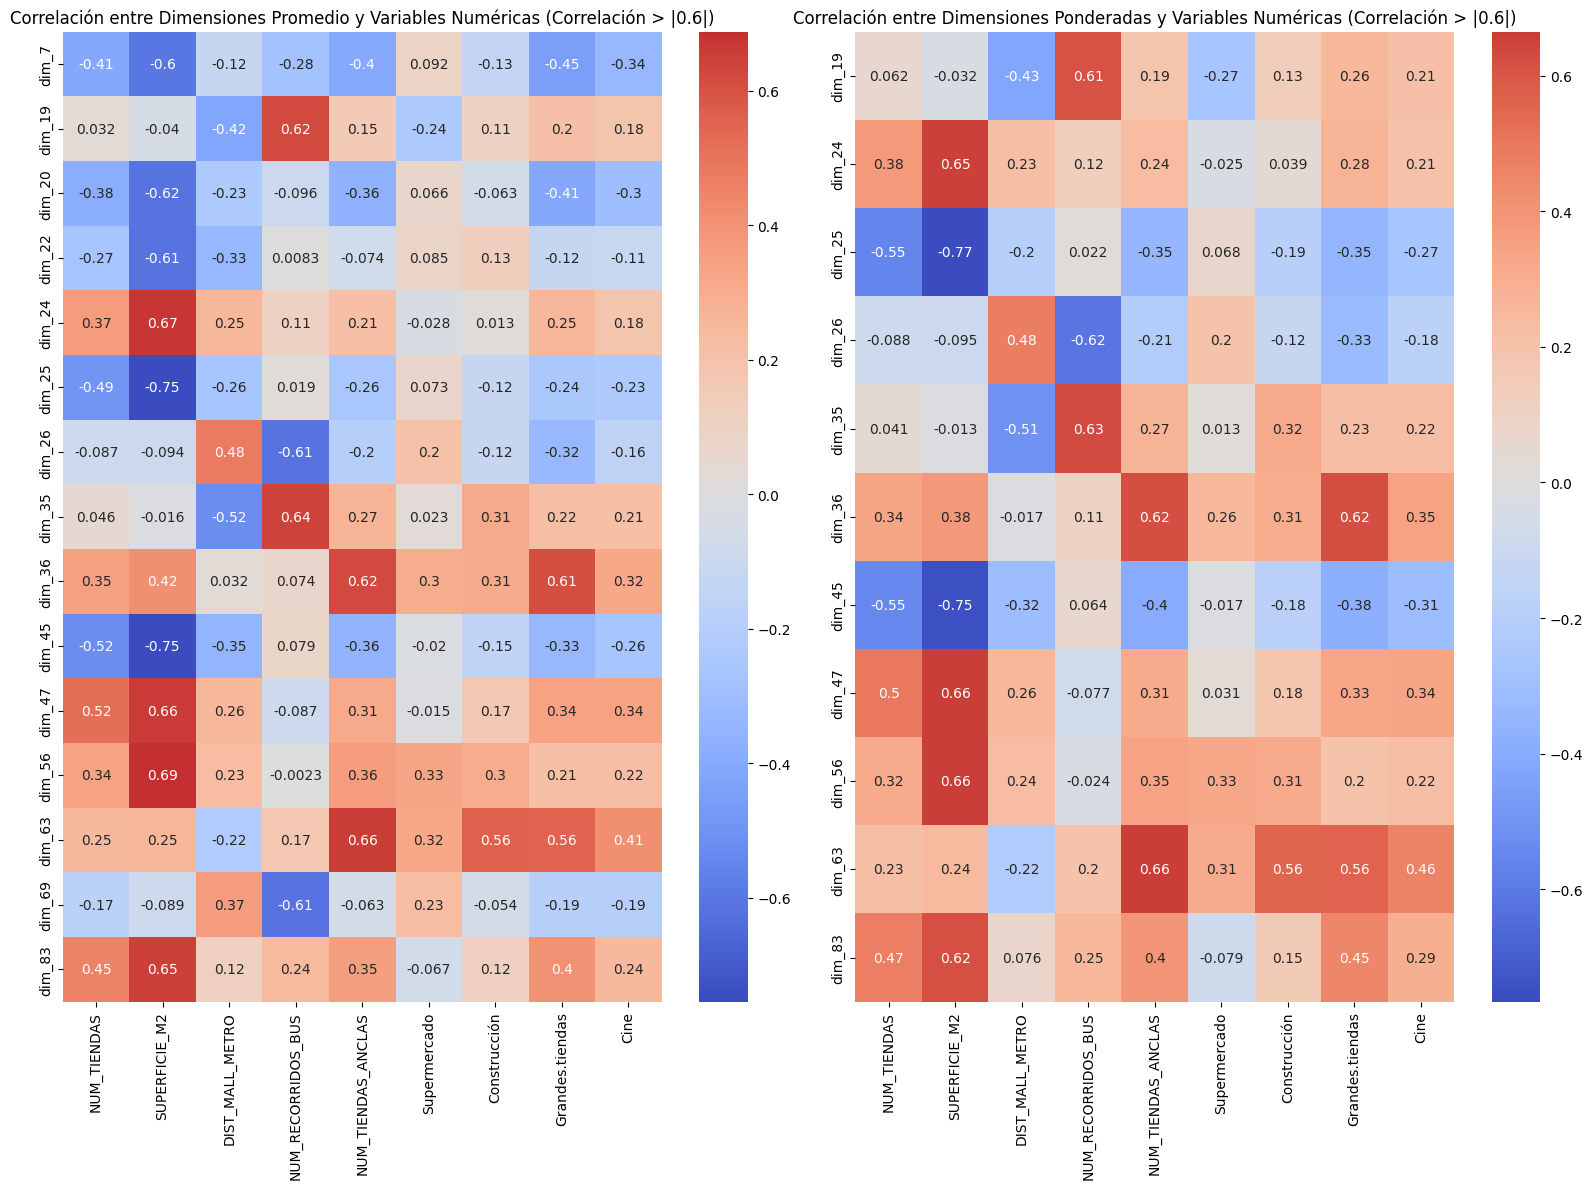

In [ ]:
# Cambiar la unión para reflejar los diferentes nombres de columnas
df_mall_fttx = pd.merge(resultados_fttx, df[['MALL_NAME', 'NUM_TIENDAS', 
    'SUPERFICIE_M2', 'DIST_MALL_METRO', 'NUM_RECORRIDOS_BUS', 'NUM_TIENDAS_ANCLAS', 
    'Supermercado', 'Construcción', 'Grandes.tiendas', 'Cine']], 
    left_on='Centro Comercial', right_on='MALL_NAME')

# Eliminar la columna 'MALL_NAME' si no la necesitas después de la unión
df_mall_fttx.drop(columns=['MALL_NAME'], inplace=True)

# Extraer las dimensiones de los vectores promedio en columnas separadas
dimensiones_fttx_prom = pd.DataFrame(df_mall_fttx['vector_promedio'].to_list(), index=df_mall_fttx.index)

# Asignar nombres a las columnas de las dimensiones, por ejemplo: 'dim_1', 'dim_2', ..., 'dim_n'
dimensiones_fttx_prom.columns = [f'dim_{i+1}' for i in range(dimensiones_fttx_prom.shape[1])]

# Extraer las dimensiones de los vectores ponderados en columnas separadas
dimensiones_fttx_ponderado = pd.DataFrame(df_mall_fttx['vector_ponderado'].to_list(), index=df_mall_fttx.index)

# Asignar nombres a las columnas de las dimensiones ponderadas, por ejemplo: 'dim_1', 'dim_2', ..., 'dim_n'
dimensiones_fttx_ponderado.columns = [f'dim_{i+1}' for i in range(dimensiones_fttx_ponderado.shape[1])]

# Añadir las variables numéricas al DataFrame de dimensiones promedio
dimensiones_fttx_prom = pd.concat([dimensiones_fttx_prom, df_mall_fttx[['NUM_TIENDAS', 'SUPERFICIE_M2', 
    'DIST_MALL_METRO', 'NUM_RECORRIDOS_BUS', 'NUM_TIENDAS_ANCLAS', 
    'Supermercado', 'Construcción', 'Grandes.tiendas', 'Cine']]], axis=1)

# Añadir las variables numéricas al DataFrame de dimensiones ponderadas
dimensiones_fttx_ponderado = pd.concat([dimensiones_fttx_ponderado, df_mall_fttx[['NUM_TIENDAS', 'SUPERFICIE_M2', 
    'DIST_MALL_METRO', 'NUM_RECORRIDOS_BUS', 'NUM_TIENDAS_ANCLAS', 
    'Supermercado', 'Construcción', 'Grandes.tiendas', 'Cine']]], axis=1)

# Calcular la matriz de correlación para vectores promedio
correlation_matrix_prom = dimensiones_fttx_prom.corr()

# Calcular la matriz de correlación para vectores ponderados
correlation_matrix_ponderado = dimensiones_fttx_ponderado.corr()

# Filtrar las correlaciones entre las dimensiones promedio y las variables numéricas
correlation_results_prom = correlation_matrix_prom.loc[
    dimensiones_fttx_prom.columns[:-9],  # Aquí seleccionamos solo las dimensiones promedio
    ['NUM_TIENDAS', 'SUPERFICIE_M2', 'DIST_MALL_METRO', 'NUM_RECORRIDOS_BUS', 
     'NUM_TIENDAS_ANCLAS', 'Supermercado', 'Construcción', 'Grandes.tiendas', 'Cine']
]

# Filtrar las correlaciones entre las dimensiones ponderadas y las variables numéricas
correlation_results_ponderado = correlation_matrix_ponderado.loc[
    dimensiones_fttx_ponderado.columns[:-9],  # Aquí seleccionamos solo las dimensiones ponderadas
    ['NUM_TIENDAS', 'SUPERFICIE_M2', 'DIST_MALL_METRO', 'NUM_RECORRIDOS_BUS', 
     'NUM_TIENDAS_ANCLAS', 'Supermercado', 'Construcción', 'Grandes.tiendas', 'Cine']
]

# Aplicar filtro para ambas matrices: mantener filas que tengan al menos una correlación mayor a 0.6 en valor absoluto
correlation_results_prom = correlation_results_prom[
    correlation_results_prom.abs().max(axis=1) > 0.6
]

correlation_results_ponderado = correlation_results_ponderado[
    correlation_results_ponderado.abs().max(axis=1) > 0.6
]

# Crear un mapa de calor combinado
plt.figure(figsize=(16, 12))

# Subplot 1: Correlación para vectores promedio
plt.subplot(1, 2, 1)
sns.heatmap(correlation_results_prom, annot=True, cmap='coolwarm', center=0)
plt.title("Correlación entre Dimensiones Promedio y Variables Numéricas (Correlación > |0.6|)")

# Subplot 2: Correlación para vectores ponderados
plt.subplot(1, 2, 2)
sns.heatmap(correlation_results_ponderado, annot=True, cmap='coolwarm', center=0)
plt.title("Correlación entre Dimensiones Ponderadas y Variables Numéricas (Correlación > |0.6|)")

plt.tight_layout()
plt.show()

In [ ]:
# Función para extraer las dimensiones 60, 72 y 98 de un vector
def extraer_dimensiones(vector):
    return vector[[59, 71, 97]]  # Índices 59, 71 y 97

# Aplicar la función para extraer las dimensiones
df_resenas[['dim_60', 'dim_72', 'dim_98']] = df_resenas['vector_resena'].apply(lambda x: pd.Series(extraer_dimensiones(x)))

# Definir umbrales para alta y baja para cada dimensión
umbral_alto_60 = df_resenas['dim_60'].quantile(0.90)
umbral_bajo_60 = df_resenas['dim_60'].quantile(0.10)
umbral_alto_72 = df_resenas['dim_72'].quantile(0.90)
umbral_bajo_72 = df_resenas['dim_72'].quantile(0.10)
umbral_alto_98 = df_resenas['dim_98'].quantile(0.90)
umbral_bajo_98 = df_resenas['dim_98'].quantile(0.10)

# Filtrar las reseñas que cumplen los criterios para las tres dimensiones simultáneamente
reseñas_alta_todas = df_resenas[
    (df_resenas['dim_60'] > umbral_alto_60) &
    (df_resenas['dim_72'] > umbral_alto_72) &
    (df_resenas['dim_98'] > umbral_alto_98)
]

reseñas_baja_todas = df_resenas[
    (df_resenas['dim_60'] < umbral_bajo_60) &
    (df_resenas['dim_72'] < umbral_bajo_72) &
    (df_resenas['dim_98'] < umbral_bajo_98)
]

# Ordenar las reseñas en orden descendente para las dimensiones altas
reseñas_alta_todas_ordenadas = reseñas_alta_todas[['Centro Comercial', 'Reseña', 'dim_60', 'dim_72', 'dim_98']].sort_values(by=['dim_60', 'dim_72', 'dim_98'], ascending=False)

# Ordenar las reseñas en orden ascendente para las dimensiones bajas
reseñas_baja_todas_ordenadas = reseñas_baja_todas[['Centro Comercial', 'Reseña', 'dim_60', 'dim_72', 'dim_98']].sort_values(by=['dim_60', 'dim_72', 'dim_98'], ascending=True)

reseñas_baja_todas_ordenadas


,Centro Comercial,Reseña,dim_60,dim_72,dim_98
3352,Open Plaza Puente Alto,"Muchas cosas en el mall ropa, zapatillas, repu...",0.084473,-0.009635,-0.270566
2515,Mall Sport,Mall exclusivamente de deporte,0.084649,-0.113526,-0.369621
1658,Portal La Dehesa,Es un centro comercial grande donde encuentras...,0.099296,-0.020296,-0.243950
2388,Espacio Urbano Puente Alto,Supermercado Lider Tienda Paris Tienda Skecher...,0.101871,-0.024579,-0.275978
606,Mall Plaza Norte,Me gusta ir porque ahí encuentro lo que necesi...,0.106768,0.015482,-0.258371
1908,Mall Vivo Imperio,"Muy completo para ser un mall ""pequeño"". Varie...",0.111471,-0.030812,-0.313078
1174,Mall Plaza Tobalaba,Es un centro comercial donde encuentras las 3 ...,0.113526,-0.012672,-0.298441
1293,Mall Florida Center,Se pueden encontrar desde tiendas de vestuario...,0.115992,-0.002314,-0.275832
2291,Espacio Urbano Gran Avenida,"Visite el supermercados Líder,muy completo, gr...",0.117273,0.010759,-0.249713
2463,Mall Sport,Variadas disciplinas del deporte Precios algo ...,0.119898,0.019663,-0.251291


In [ ]:
# Función para extraer la dimensión 98 de un vector
def extraer_dimension_98(vector):
    return vector[97]  # Índice 97 porque las dimensiones se indexan desde 0

# Aplicar la función para extraer la dimensión 98
df_resenas['dim_98'] = df_resenas['vector_resena'].apply(extraer_dimension_98)

# Definir umbrales para alta y baja
high_threshold = df_resenas['dim_98'].quantile(0.90)
low_threshold = df_resenas['dim_98'].quantile(0.10)

# Filtrar las reseñas con dimensión 98 alta o baja
reseñas_alta = df_resenas[df_resenas['dim_98'] > high_threshold]
reseñas_baja = df_resenas[df_resenas['dim_98'] < low_threshold]

# Ordenar las reseñas con dimensión 98 alta en orden descendente
reseñas_alta_ordenadas = reseñas_alta[['Centro Comercial', 'Reseña', 'dim_98']].sort_values(by='dim_98', ascending=False)

# Ordenar las reseñas con dimensión 98 baja en orden ascendente
reseñas_baja_ordenadas = reseñas_baja[['Centro Comercial', 'Reseña', 'dim_98']].sort_values(by='dim_98', ascending=True)

# Mostrar las reseñas ordenadas
print("Reseñas con dimensión 98 alta (orden descendente):")
reseñas_alta_ordenadas .head(10)




Reseñas con dimensión 98 alta (orden descendente):


,Centro Comercial,Reseña,dim_98
1756,Mall Pumay,Un poco más de gente que otros días de la sema...,0.134519
167,Parque Arauco,"Como fin de semana, bastante concurrido",0.086363
1427,Mall Paseo Quilín,Muy grato el rato en el mall. No había mucha g...,0.076937
2659,Espacio Urbano La Dehesa,Muy tranquilo y poca gente,0.076836
2267,Espacio Urbano Gran Avenida,"Está cada día mejor,hay seguridad",0.068294
3373,Open Plaza Puente Alto,Bastante gente a esta hora,0.065906
3303,Mall Espacio Urbano Las Rejas,Si aceptable para comprar aunque los sigan tod...,0.058708
347,Mall Plaza Oeste,"Muy bueno pero no hay q ir fin de semana, un c...",0.056331
1566,Mall Plaza Alameda,Cero servicio al cliente. No conseguí taxis po...,0.053720
2816,Mall Vivo Los Trapenses,La calle no está hecha para el peatón. Un tray...,0.049443


In [ ]:
# Filtrar el DataFrame para obtener las características del centro comercial "Open Plaza Puente Alto"
caracteristicas_open_plaza = df[df['MALL_NAME'] == 'Open Plaza Puente Alto'][[
    'MALL_NAME', 'NUM_TIENDAS', 'SUPERFICIE_M2', 'DIST_MALL_METRO', 
    'NUM_RECORRIDOS_BUS', 'NUM_TIENDAS_ANCLAS', 'Supermercado', 
    'Construcción', 'Grandes.tiendas', 'Cine'
]]

# Mostrar las característica
caracteristicas_open_plaza.drop_duplicates()


,MALL_NAME,NUM_TIENDAS,SUPERFICIE_M2,DIST_MALL_METRO,NUM_RECORRIDOS_BUS,NUM_TIENDAS_ANCLAS,Supermercado,Construcción,Grandes.tiendas,Cine
147771,Open Plaza Puente Alto,13.0,13600.0,0.257225,5,1.0,1.0,0.0,0.0,0.0


In [ ]:
# Extraer dimensión 98 de los vectores promedio
resultados_fttx['dim_98_promedio'] = resultados_fttx['vector_promedio'].apply(extraer_dimension_98)

# Definir umbrales para alta y baja
high_threshold_promedio = resultados_fttx['dim_98_promedio'].quantile(0.90)
low_threshold_promedio = resultados_fttx['dim_98_promedio'].quantile(0.10)


# Filtrar los centros comerciales con dimensión 98 alta o baja para vectores promedio
centros_alta_promedio = resultados_fttx[resultados_fttx['dim_98_promedio'] > high_threshold_promedio]
centros_baja_promedio = resultados_fttx[resultados_fttx['dim_98_promedio'] < low_threshold_promedio]

# Ordenar los centros comerciales en función de la dimensión 98 (vectores promedio)
centros_alta_promedio_ordenados = centros_alta_promedio[['Centro Comercial', 'dim_98_promedio']].sort_values(by='dim_98_promedio', ascending=False)
centros_baja_promedio_ordenados = centros_baja_promedio[['Centro Comercial', 'dim_98_promedio']].sort_values(by='dim_98_promedio', ascending=True)



# Mostrar los resultados
print("Centros comerciales con dimensión 98 alta (vectores promedio):")
centros_alta_promedio_ordenados.head(10)





Centros comerciales con dimensión 98 alta (vectores promedio):


,Centro Comercial,dim_98_promedio
28,Mall Vivo Centro,-0.073616
12,Mall Florida Center,-0.075518
2,Arauco Estación,-0.077006
23,Mall Plaza Vespucio,-0.077225


In [ ]:
print("\nCentros comerciales con dimensión 98 baja (vectores promedio):")
centros_baja_promedio_ordenados


Centros comerciales con dimensión 98 baja (vectores promedio):


,Centro Comercial,dim_98_promedio
3,Casa Costanera,-0.118561
8,Espacio Urbano Puente Alto,-0.113679
27,Mall Sport,-0.113532
5,Espacio Urbano Gran Avenida,-0.111866


In [ ]:
# Filtrar el DataFrame para obtener las características del centro comercial "Open Plaza Puente Alto"
caracteristicas_open_plaza = df[df['MALL_NAME'] == ('Mall Plaza Oeste' )][[
    'MALL_NAME', 'NUM_TIENDAS', 'SUPERFICIE_M2', 'DIST_MALL_METRO', 
    'NUM_RECORRIDOS_BUS', 'NUM_TIENDAS_ANCLAS', 'Supermercado', 
    'Construcción', 'Grandes.tiendas', 'Cine'
]]

# Mostrar las característica
caracteristicas_open_plaza.drop_duplicates()

,MALL_NAME,NUM_TIENDAS,SUPERFICIE_M2,DIST_MALL_METRO,NUM_RECORRIDOS_BUS,NUM_TIENDAS_ANCLAS,Supermercado,Construcción,Grandes.tiendas,Cine
262704,Mall Plaza Oeste,324.0,145000.0,2.240426,5,7.0,1.0,1.0,4.0,1.0


#### Gráfico de palabras

In [ ]:

# Obtener las 100 palabras más comunes
common_words = list(ft_model.wv.index_to_key[:100])

# Obtener los embeddings para estas palabras
word_vectors = np.array([ft_model.wv[word] for word in common_words])

# Reducir la dimensionalidad de los embeddings
tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Crear un DataFrame para facilitar la visualización
df_palabras = pd.DataFrame(word_vectors_2d, columns=['x', 'y'])
df_palabras['word'] = common_words


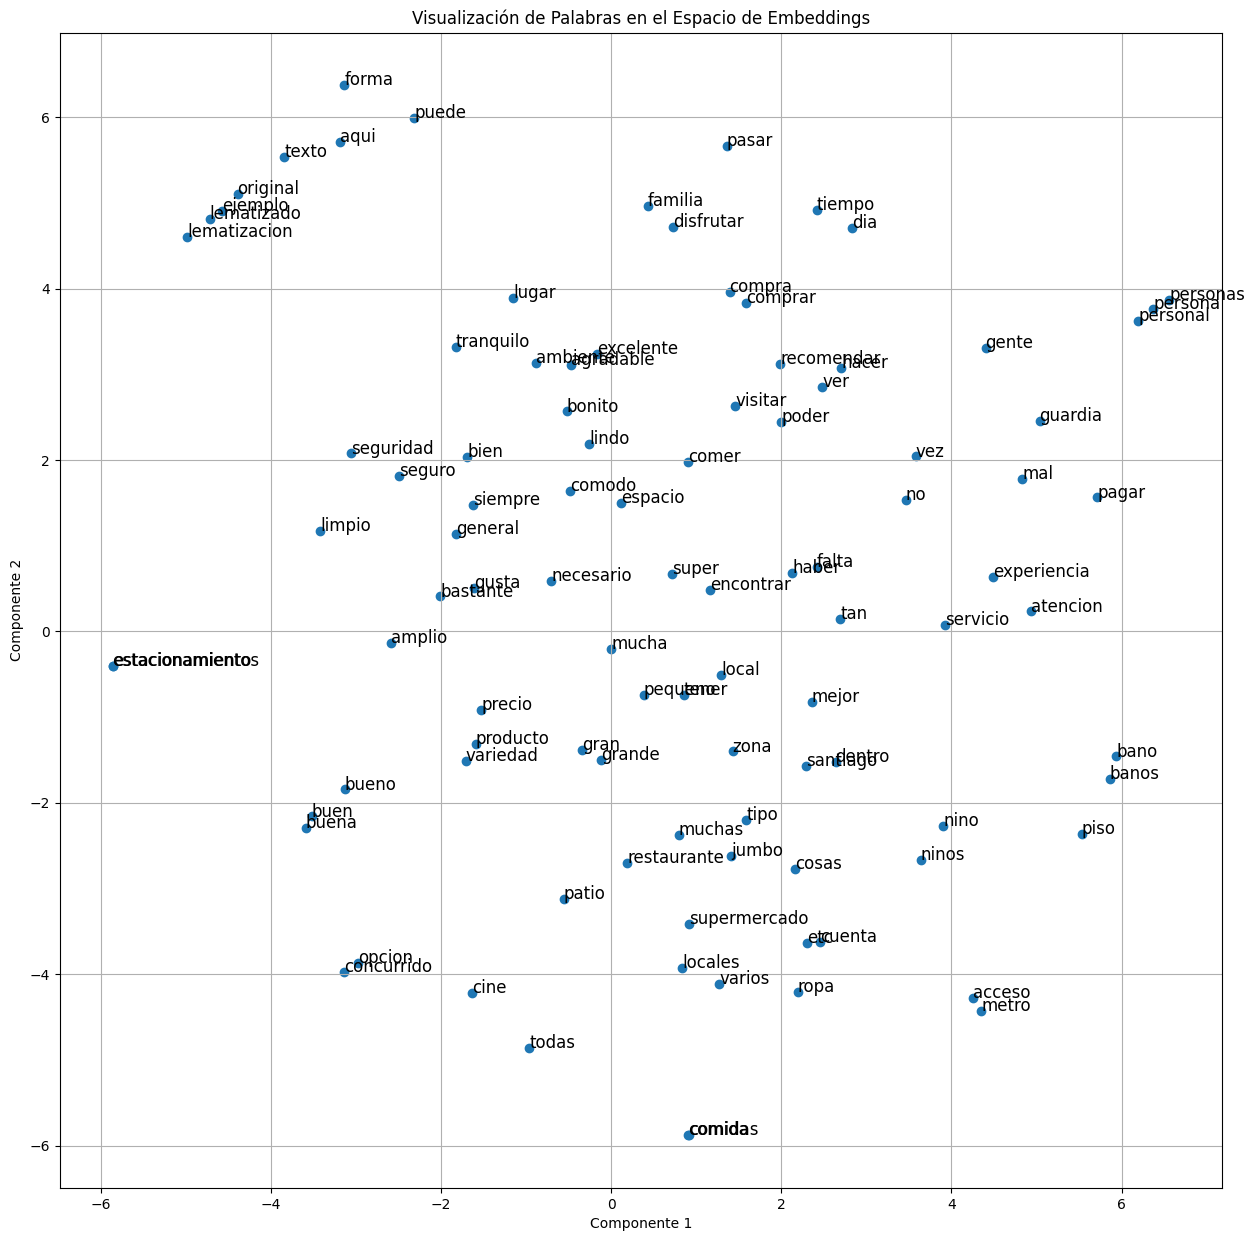

In [ ]:
plt.figure(figsize=(15, 15))
plt.scatter(df_palabras['x'], df_palabras['y'])

# Añadir etiquetas para las palabras
for i, row in df_palabras.iterrows():
    plt.text(row['x'], row['y'], row['word'], fontsize=12)

plt.title('Visualización de Palabras en el Espacio de Embeddings')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.show()


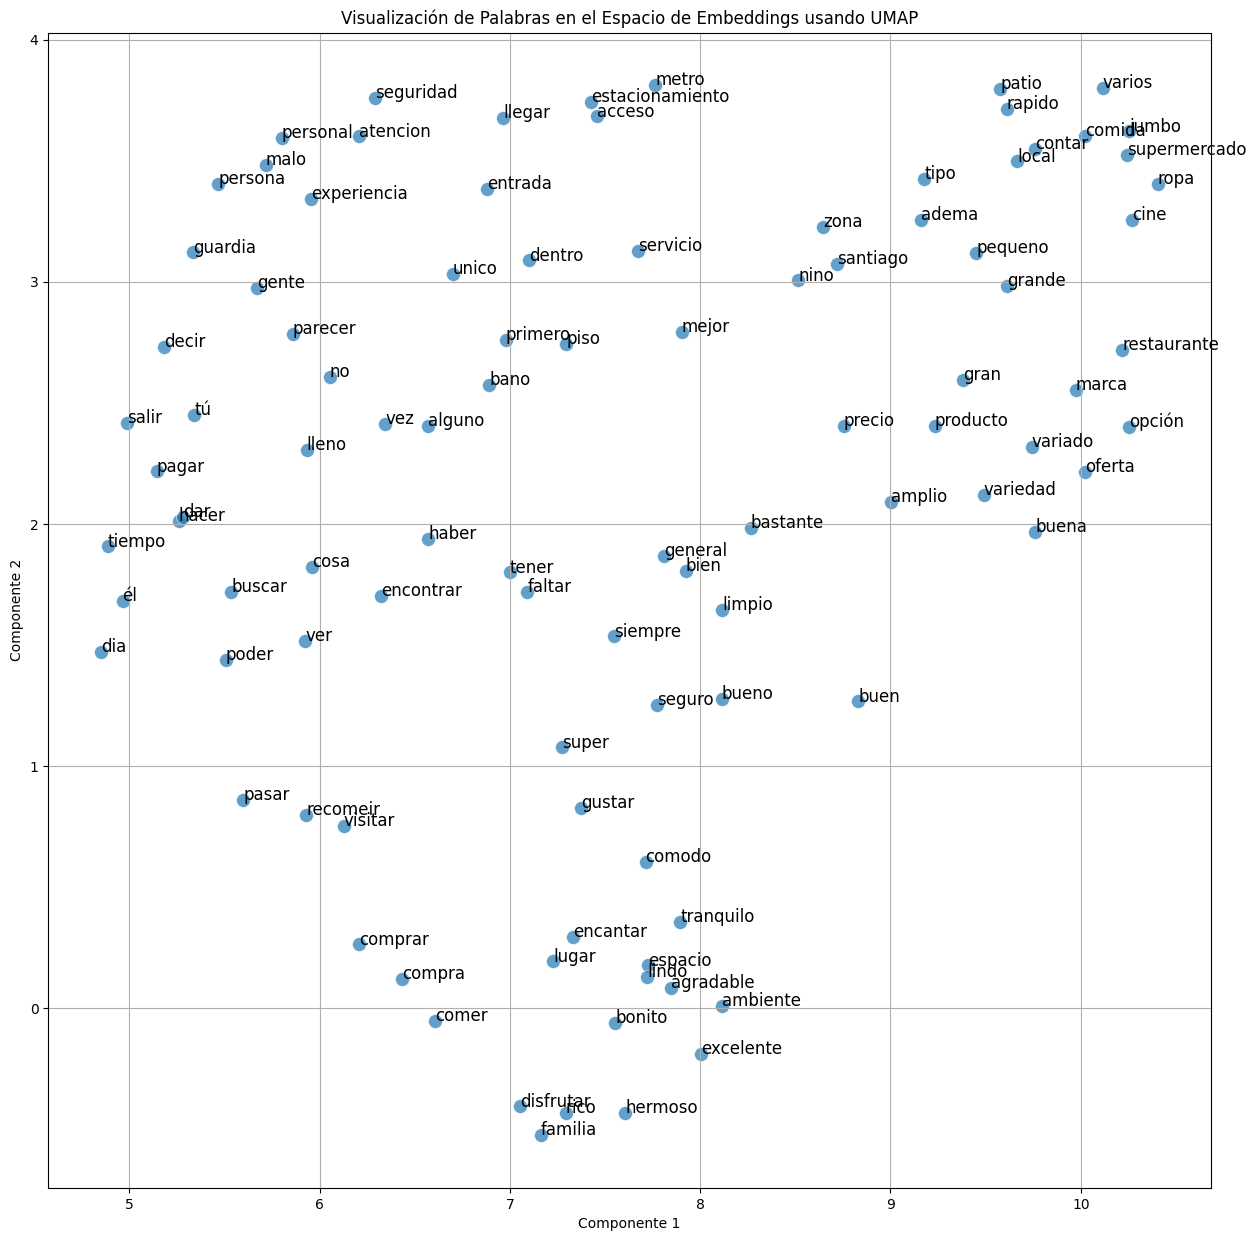

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from gensim.models import FastText

# Supongamos que ya tienes un modelo FastText cargado como `ft_model`

# Obtener las 100 palabras más comunes
common_words = list(ft_model.wv.index_to_key[:100])

# Obtener los embeddings para estas palabras
word_vectors = np.array([ft_model.wv[word] for word in common_words])

# Reducir la dimensionalidad de los embeddings usando UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
word_vectors_2d = umap_model.fit_transform(word_vectors)

# Crear un DataFrame para facilitar la visualización
df_palabras = pd.DataFrame(word_vectors_2d, columns=['x', 'y'])
df_palabras['word'] = common_words

# Crear la visualización
plt.figure(figsize=(15, 15))
plt.scatter(df_palabras['x'], df_palabras['y'], s=100, alpha=0.7, edgecolors='w', linewidth=0.5)

# Añadir etiquetas para las palabras
for i, row in df_palabras.iterrows():
    plt.text(row['x'], row['y'], row['word'], fontsize=12)

plt.title('Visualización de Palabras en el Espacio de Embeddings usando UMAP')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.show()


In [ ]:
# Obtener las palabras más similares a una palabra específica
print(ft_model.wv.most_similar('cine'))

[('terraza', 0.9819298386573792), ('juegos', 0.9735314249992371), ('ferreteria', 0.9728464484214783), ('feria', 0.9711338877677917), ('libreria', 0.9708797335624695), ('terrazar', 0.9692527651786804), ('retail', 0.9673032760620117), ('heladeria', 0.9669983386993408), ('happyland', 0.9665964245796204), ('restaurants', 0.9655814170837402)]


In [ ]:
similar_words = ft_model.wv.most_similar('feo', topn=10)
print(similar_words)


[('animal', 0.9980116486549377), ('arriba', 0.997965395450592), ('flojo', 0.9968936443328857), ('isla', 0.9965056777000427), ('requerir', 0.9960674047470093), ('jaula', 0.9959383010864258), ('abrio', 0.9954750537872314), ('todavio', 0.9954367280006409), ('hit', 0.9953479766845703), ('costumbre', 0.9951286315917969)]


#### Gráfico de Reseñas

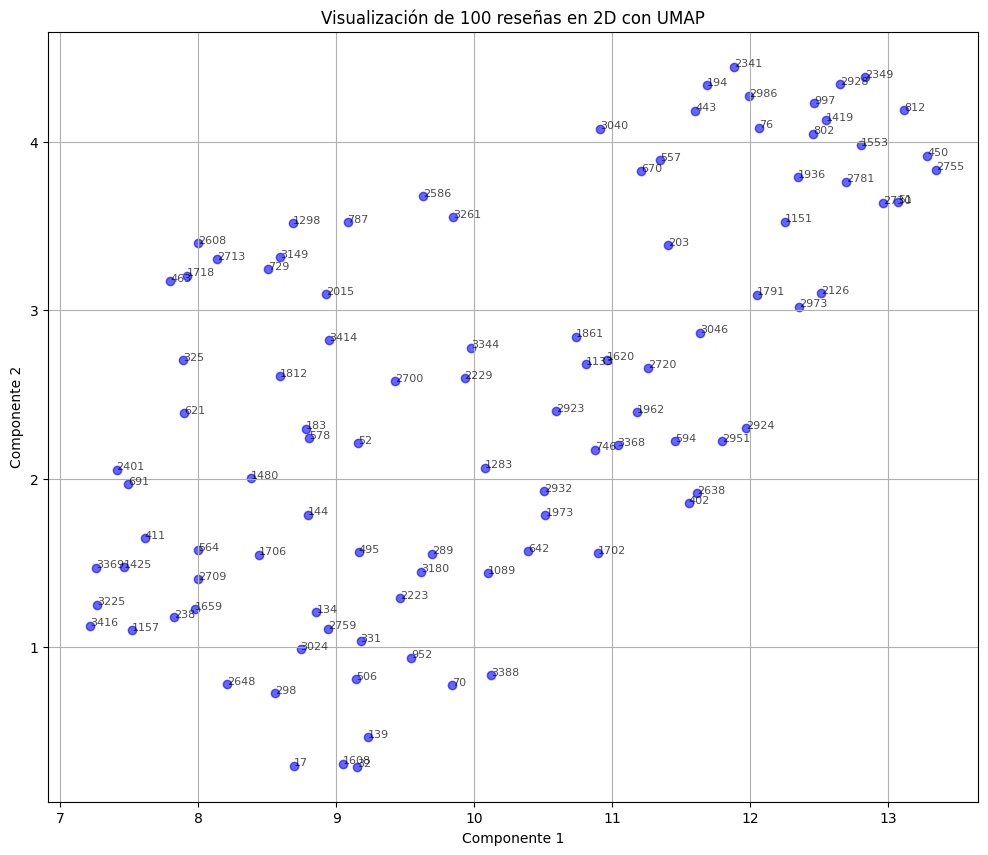

In [ ]:
# Seleccionar aleatoriamente 150 reseñas
sample_df = df_resenas.sample(n=100, random_state=42)

# Obtener los vectores de las reseñas seleccionadas
vectors = np.array(sample_df['vector_resena'].tolist())

# Reducir la dimensionalidad de los vectores con UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
vectors_umap = umap_model.fit_transform(vectors)

# Crear el gráfico de dispersión
plt.figure(figsize=(12, 10))
plt.scatter(vectors_umap[:, 0], vectors_umap[:, 1], c='blue', alpha=0.6)

# Añadir etiquetas con el índice de la reseña
for i, idx in enumerate(sample_df.index):
    plt.annotate(idx, (vectors_umap[i, 0], vectors_umap[i, 1]), fontsize=8, alpha=0.7)

plt.title('Visualización de 100 reseñas en 2D con UMAP')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.show()


In [ ]:
df_resenas.loc[2713, 'Reseña']


'Lindo lugar , para pasear y realizar compras'

In [ ]:
df_resenas.loc[2638, 'Reseña']

'Una especie de Dolphin Mall Chileno por su parecido arquitectónico con el centro comercial de Miami. Es un mal pequeño pero con todo lo necesario. Recomendable.'

In [ ]:
df_resenas.loc[1962, 'Reseña']

'Un buen lugar, pero lo que le baja estrellas esq en la zona hay mucha delincuencia   '

In [ ]:
df_resenas.loc[238, 'Reseña']

'Gran variedad de grandes tiendas y puestos de emprendedores también. Por lo general siempre está muy concurrido. Cuenta con un patio de comidas y cine.'

In [ ]:
df_resenas.loc[787, 'Reseña']

'Agradable, nunca está tan lleno y se puede caminar tranquilamente'

In [ ]:
df_resenas.loc[2015, 'Reseña']

'Bonito lugar como para dar un paseo 😁'

#### Gráfico Centro Comercial

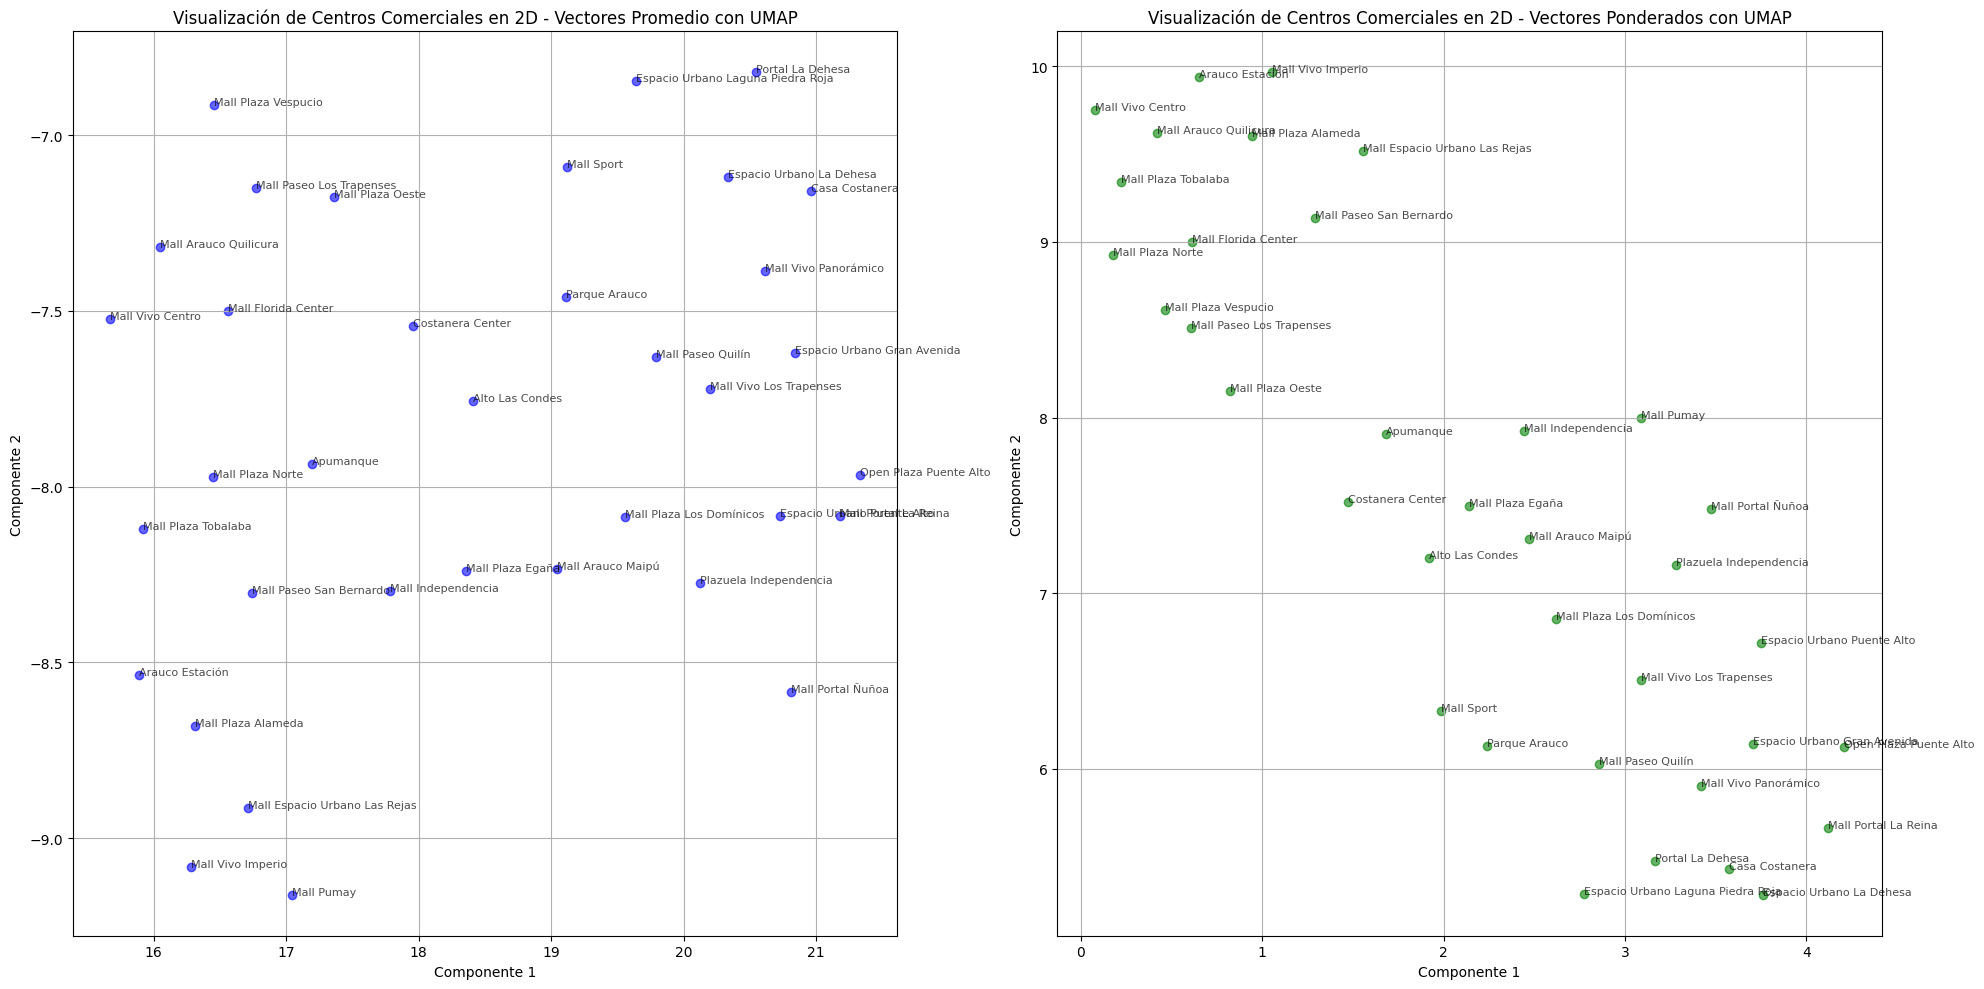

In [ ]:
vectors_promedio = np.array(resultados_fttx['vector_promedio'].tolist())
vectors_ponderado = np.array(resultados_fttx['vector_ponderado'].tolist())

# Reducir la dimensionalidad de los vectores promedio con UMAP
umap_model_promedio = umap.UMAP(n_components=2, random_state=42)
vectors_umap_promedio = umap_model_promedio.fit_transform(vectors_promedio)

# Reducir la dimensionalidad de los vectores ponderados con UMAP
umap_model_ponderado = umap.UMAP(n_components=2, random_state=42)
vectors_umap_ponderado = umap_model_ponderado.fit_transform(vectors_ponderado)

# Crear subplots para ambos gráficos
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Gráfico de dispersión para vectores promedio
axs[0].scatter(vectors_umap_promedio[:, 0], vectors_umap_promedio[:, 1], c='blue', alpha=0.6)
axs[0].set_title('Visualización de Centros Comerciales en 2D - Vectores Promedio con UMAP')
axs[0].set_xlabel('Componente 1')
axs[0].set_ylabel('Componente 2')
axs[0].grid(True)

# Añadir etiquetas para vectores promedio
for i, centro in enumerate(resultados_fttx['Centro Comercial']):
    axs[0].annotate(centro, (vectors_umap_promedio[i, 0], vectors_umap_promedio[i, 1]), fontsize=8, alpha=0.7)

# Gráfico de dispersión para vectores ponderados
axs[1].scatter(vectors_umap_ponderado[:, 0], vectors_umap_ponderado[:, 1], c='green', alpha=0.6)
axs[1].set_title('Visualización de Centros Comerciales en 2D - Vectores Ponderados con UMAP')
axs[1].set_xlabel('Componente 1')
axs[1].set_ylabel('Componente 2')
axs[1].grid(True)

# Añadir etiquetas para vectores ponderados
for i, centro in enumerate(resultados_fttx['Centro Comercial']):
    axs[1].annotate(centro, (vectors_umap_ponderado[i, 0], vectors_umap_ponderado[i, 1]), fontsize=8, alpha=0.7)

# Ajustar el diseño de los gráficos
plt.tight_layout()
plt.show()

#### Clúster

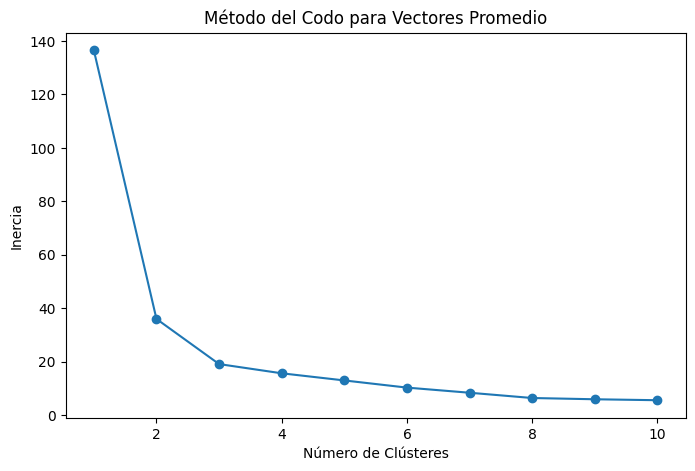

In [ ]:
from sklearn.cluster import KMeans

# Determinar el número óptimo de clústeres usando el método del codo
inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(vectors_umap_ponderado)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del Codo para Vectores Promedio')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inercia')
plt.show()





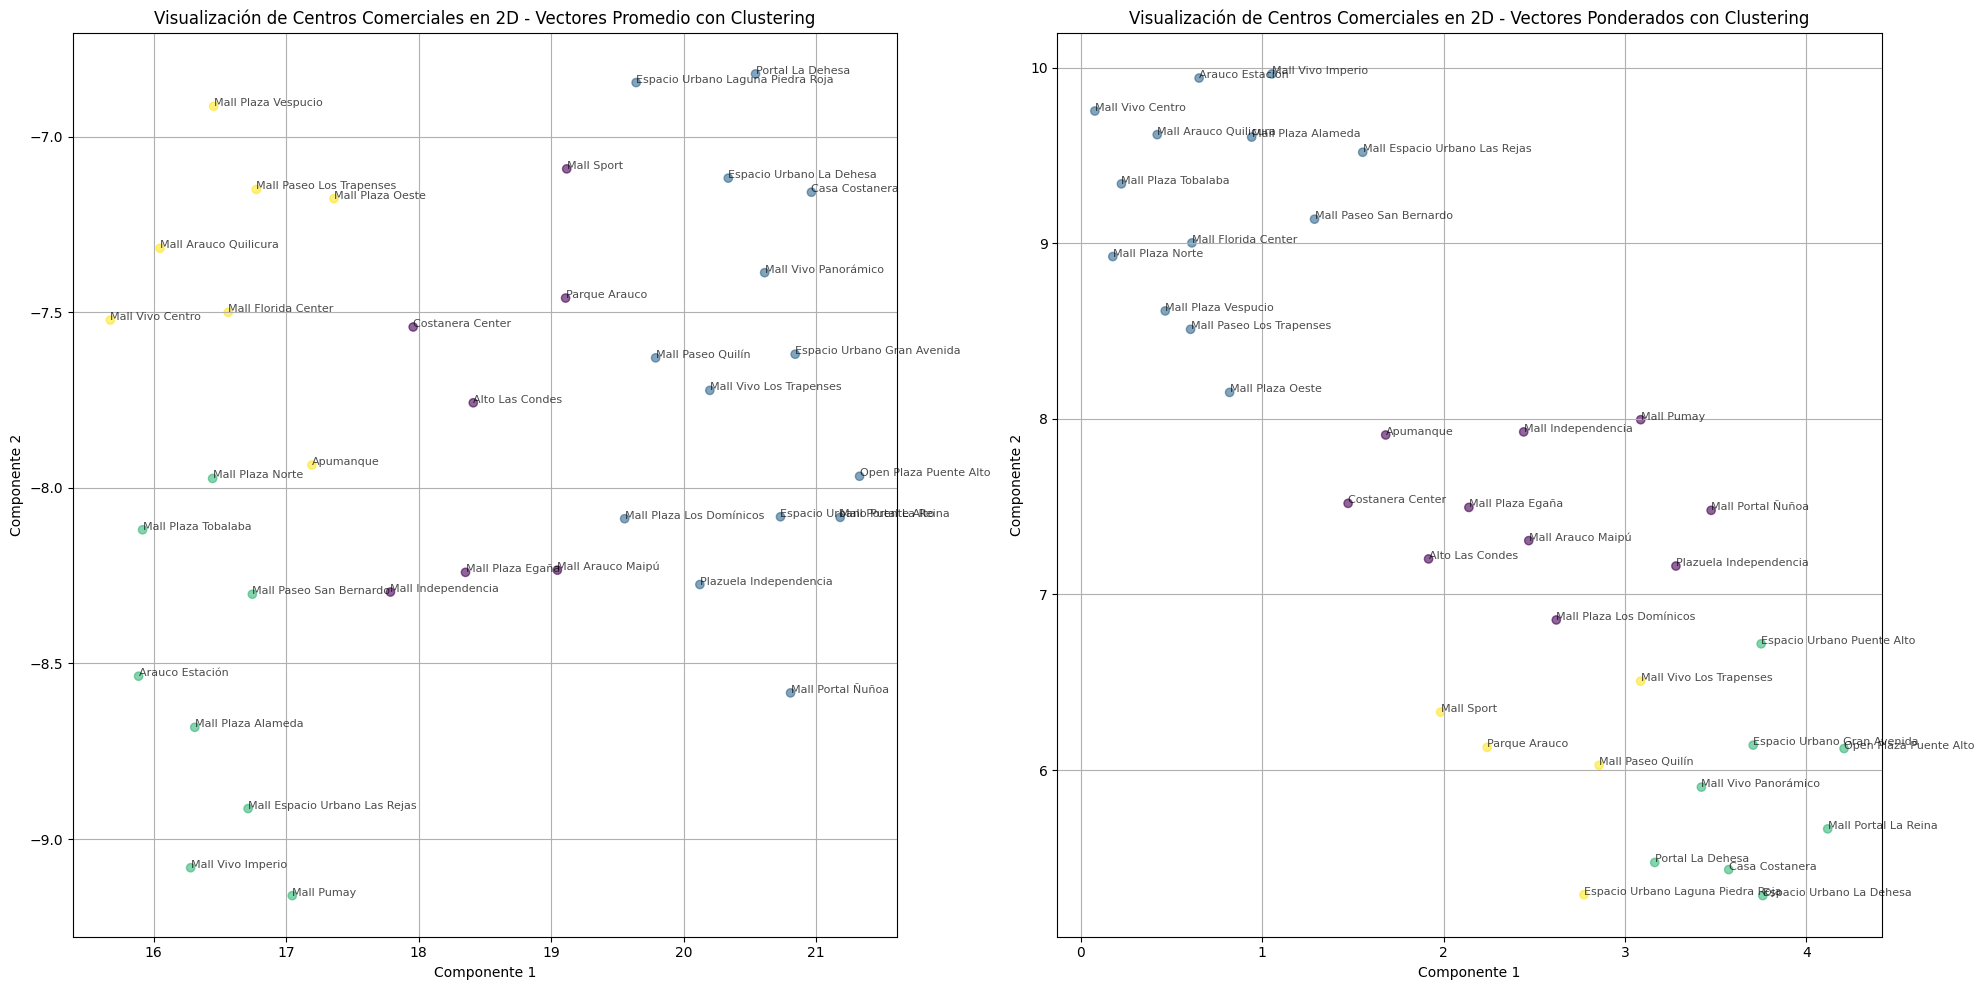

In [ ]:
import umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans  # Puedes usar el algoritmo que prefieras

# Obtener los vectores promedio y ponderados
vectors_promedio = np.array(resultados_fttx['vector_promedio'].tolist())
vectors_ponderado = np.array(resultados_fttx['vector_ponderado'].tolist())

# Reducir la dimensionalidad de los vectores promedio con UMAP
umap_model_promedio = umap.UMAP(n_components=2, random_state=42)
vectors_umap_promedio = umap_model_promedio.fit_transform(vectors_promedio)

# Reducir la dimensionalidad de los vectores ponderados con UMAP
umap_model_ponderado = umap.UMAP(n_components=2, random_state=42)
vectors_umap_ponderado = umap_model_ponderado.fit_transform(vectors_ponderado)

# Realizar clustering (puedes cambiar el algoritmo o los parámetros según sea necesario)
kmeans_promedio = KMeans(n_clusters=4, random_state=42)  # Ajusta el número de clústeres según el método del codo
clusters_promedio = kmeans_promedio.fit_predict(vectors_umap_promedio)

kmeans_ponderado = KMeans(n_clusters=4, random_state=42)  # Ajusta el número de clústeres según el método del codo
clusters_ponderado = kmeans_ponderado.fit_predict(vectors_umap_ponderado)

# Agregar los clústeres al DataFrame resultados_fttx
resultados_fttx['Cluster_Promedio'] = clusters_promedio
resultados_fttx['Cluster_Ponderado'] = clusters_ponderado

# Crear subplots para ambos gráficos
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Gráfico de dispersión para vectores promedio con clústeres
scatter_promedio = axs[0].scatter(vectors_umap_promedio[:, 0], vectors_umap_promedio[:, 1], c=clusters_promedio, cmap='viridis', alpha=0.6)
axs[0].set_title('Visualización de Centros Comerciales en 2D - Vectores Promedio con Clustering')
axs[0].set_xlabel('Componente 1')
axs[0].set_ylabel('Componente 2')
axs[0].grid(True)

# Añadir etiquetas para vectores promedio
for i, centro in enumerate(resultados_fttx['Centro Comercial']):
    axs[0].annotate(centro, (vectors_umap_promedio[i, 0], vectors_umap_promedio[i, 1]), fontsize=8, alpha=0.7)


# Gráfico de dispersión para vectores ponderados con clústeres
scatter_ponderado = axs[1].scatter(vectors_umap_ponderado[:, 0], vectors_umap_ponderado[:, 1], c=clusters_ponderado, cmap='viridis', alpha=0.6)
axs[1].set_title('Visualización de Centros Comerciales en 2D - Vectores Ponderados con Clustering')
axs[1].set_xlabel('Componente 1')
axs[1].set_ylabel('Componente 2')
axs[1].grid(True)

# Añadir etiquetas para vectores ponderados
for i, centro in enumerate(resultados_fttx['Centro Comercial']):
    axs[1].annotate(centro, (vectors_umap_ponderado[i, 0], vectors_umap_ponderado[i, 1]), fontsize=8, alpha=0.7)



# Ajustar el diseño de los gráficos
plt.tight_layout()
plt.show()


In [ ]:
resultados_fttx

,Centro Comercial,vector_promedio,vector_ponderado,dim_98_promedio,Cluster_Promedio,Cluster_Ponderado
0,Alto Las Condes,"[-0.08102741, 0.45798883, 0.3035436, 0.377833,...","[-0.08018020169240318, 0.45235636775140425, 0....",-0.089266,0,0
1,Apumanque,"[-0.07794862, 0.4526348, 0.29537988, 0.3839607...","[-0.07757886280083946, 0.4493500692503794, 0.2...",-0.088180,3,0
2,Arauco Estación,"[-0.08274541, 0.46996585, 0.3021667, 0.4030306...","[-0.08084524936933556, 0.4605522671471472, 0.2...",-0.077006,2,1
3,Casa Costanera,"[-0.09170879, 0.48568997, 0.332157, 0.37854552...","[-0.0887153223156929, 0.47812995573748723, 0.3...",-0.118561,1,2
4,Costanera Center,"[-0.086988255, 0.4580141, 0.29315326, 0.377153...","[-0.08616546525255493, 0.45211636113083903, 0....",-0.091455,0,0
5,Espacio Urbano Gran Avenida,"[-0.07718047167465557, 0.4848348557949066, 0.3...","[-0.07708088489016517, 0.48168126639918757, 0....",-0.111866,1,2
6,Espacio Urbano La Dehesa,"[-0.07577278, 0.4839152, 0.33944023, 0.393098,...","[-0.07608338893105342, 0.4830548007889549, 0.3...",-0.102495,1,2
7,Espacio Urbano Laguna Piedra Roja,"[-0.05050285, 0.44949424, 0.37013215, 0.409134...","[-0.050340276787870175, 0.4483406616776597, 0....",-0.096496,1,3
8,Espacio Urbano Puente Alto,"[-0.087942, 0.4941044, 0.31553018, 0.39018384,...","[-0.08579423644960947, 0.48240434744141314, 0....",-0.113679,1,2
9,Mall Arauco Maipú,"[-0.07692894, 0.4684903, 0.31782848, 0.3959075...","[-0.07635523197758527, 0.4623816413459952, 0.3...",-0.085344,0,0


### BERT

In [ ]:
import emoji
# Función para eliminar emojis
def eliminar_emojis(texto):
    return emoji.replace_emoji(texto, replace='')

# Aplicar la función de eliminación de emojis a la columna 'Reseña'
df_resenas['reseña_limpia'] = df_resenas['Reseña'].apply(eliminar_emojis) 
df_resenas['reseña_limpia'] = df_resenas['reseña_limpia'].apply(lambda x: x.lower())

In [ ]:
from transformers import BertTokenizer, BertModel
import torch


#Cargar el tokenizer y modelo BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
model = BertModel.from_pretrained('bert-base-multilingual-uncased')

#Función para obtener el vector BERT de una reseña
def obtener_vector_bert(resena, tokenizer, model):
    inputs = tokenizer(resena, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Extraer el embedding del [CLS] token, que captura el significado de la frase completa
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

#Aplicar la función a todas las reseñas y guardar los vectores en una columna
df_resenas['vector_bert'] = df_resenas['reseña_limpia'].apply(lambda x: obtener_vector_bert(x, tokenizer, model))

# Convertir los vectores en una lista de NumPy arrays
vectores_bert = np.array(df_resenas['vector_bert'].tolist())

# Aplicar PCA para reducir las dimensiones de los vectores BERT de 768 a 100 
pca = PCA(n_components=100)  # Reducción a 100 dimensiones
vectores_reducidos = pca.fit_transform(vectores_bert)

# Paso 6: Guardar los vectores reducidos en una nueva columna del DataFrame
df_resenas['vector_bert_reducido'] = list(vectores_reducidos)



#### Gráfico Reseñas

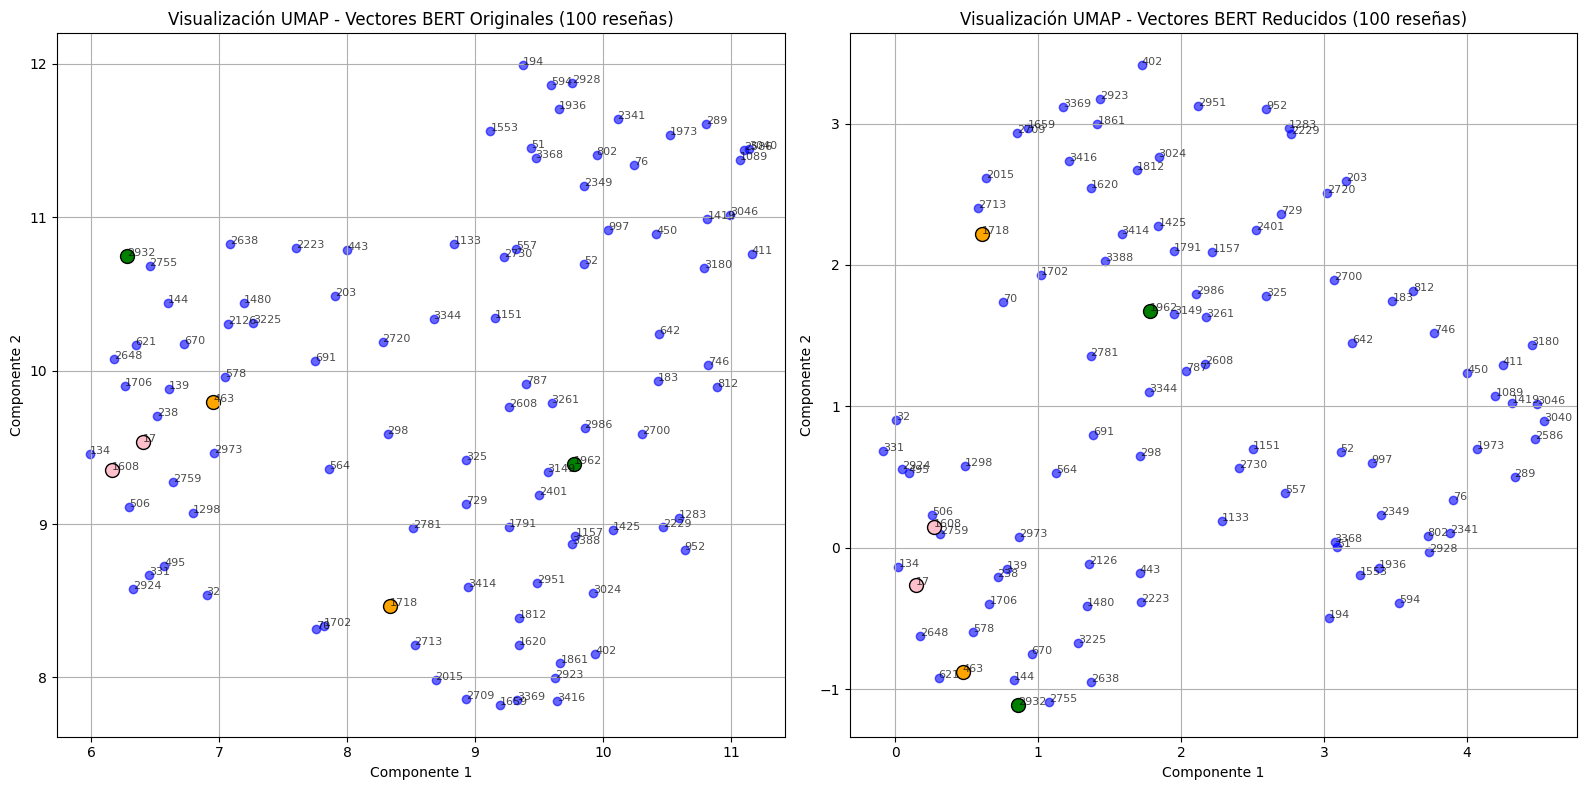

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import umap
import pandas as pd

# Obtener los vectores BERT originales y reducidos para estas 150 reseñas
vectores_bert_sample = np.array(sample_df['vector_bert'].tolist())
vectores_reducidos_sample = np.array(sample_df['vector_bert_reducido'].tolist())

# Aplicar UMAP para reducir la dimensionalidad a 2D
umap_original_sample = umap.UMAP(n_components=2, random_state=42).fit_transform(vectores_bert_sample)
umap_reducido_sample = umap.UMAP(n_components=2, random_state=42).fit_transform(vectores_reducidos_sample)

# Crear gráficos de dispersión
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Colores para las reseñas destacadas
colores_reseñas = {17: 'pink', 1608: 'pink', 2932: 'green', 1962: 'green', 463: 'orange', 1718: 'orange'}

# Graficar UMAP para vectores BERT originales
scatter_original = axs[0].scatter(umap_original_sample[:, 0], umap_original_sample[:, 1], c='blue', alpha=0.6)
axs[0].set_title('Visualización UMAP - Vectores BERT Originales (100 reseñas)')
axs[0].set_xlabel('Componente 1')
axs[0].set_ylabel('Componente 2')
axs[0].grid(True)

# Añadir etiquetas con el número de reseña en el gráfico original y marcar las reseñas destacadas
for i, idx in enumerate(sample_df.index):
    if idx in colores_reseñas:
        axs[0].scatter(umap_original_sample[i, 0], umap_original_sample[i, 1], c=colores_reseñas[idx], edgecolors='black', s=100, label=f"Reseña {idx}")
    axs[0].annotate(idx, (umap_original_sample[i, 0], umap_original_sample[i, 1]), fontsize=8, alpha=0.7)

# Graficar UMAP para vectores BERT reducidos
scatter_reducido = axs[1].scatter(umap_reducido_sample[:, 0], umap_reducido_sample[:, 1], c='blue', alpha=0.6)
axs[1].set_title('Visualización UMAP - Vectores BERT Reducidos (100 reseñas)')
axs[1].set_xlabel('Componente 1')
axs[1].set_ylabel('Componente 2')
axs[1].grid(True)

# Añadir etiquetas con el número de reseña en el gráfico reducido y marcar las reseñas destacadas
for i, idx in enumerate(sample_df.index):
    if idx in colores_reseñas:
        axs[1].scatter(umap_reducido_sample[i, 0], umap_reducido_sample[i, 1], c=colores_reseñas[idx], edgecolors='black', s=100, label=f"Reseña {idx}")
    axs[1].annotate(idx, (umap_reducido_sample[i, 0], umap_reducido_sample[i, 1]), fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()


#### Gráfico Centro Comercial

In [ ]:

# Agrupar por 'Centro Comercial' y calcular el promedio de vectores
vectores_promedio = df_resenas.groupby('Centro Comercial')['vector_bert'].apply(
    lambda x: np.mean(np.array(x.tolist()), axis=0)
).reset_index()
vectores_promedio.columns = ['Centro Comercial', 'vector_bert_prom']

# Agrupar por 'Centro Comercial' y calcular el promedio ponderado de vectores
vectores_ponderados = df_resenas.groupby('Centro Comercial').apply(
    lambda x: promedio_ponderado(x['vector_bert'].tolist(), x['ponderacion'].tolist())
).reset_index()
vectores_ponderados.columns = ['Centro Comercial', 'vector_bert_ponderado']

# Agrupar por 'Centro Comercial' y calcular el promedio de vectores reducidos
vectores_reducido = df_resenas.groupby('Centro Comercial')['vector_bert_reducido'].apply(
    lambda x: np.mean(np.array(x.tolist()), axis=0)
).reset_index()
vectores_reducido.columns = ['Centro Comercial', 'vector_bert_reducido']

# Unir los DataFrames en una sola operación
resultados_bert = pd.merge(vectores_promedio, vectores_ponderados, on='Centro Comercial')
resultados_bert = pd.merge(resultados_bert, vectores_reducido, on='Centro Comercial')


/tmp/ipykernel_11896/2014780318.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vectores_ponderados = df_resenas.groupby('Centro Comercial').apply(


In [ ]:
resultados_bert

,Centro Comercial,vector_bert_prom,vector_bert_ponderado,vector_bert_reducido,Cluster_Promedio,Cluster_Ponderado,Cluster_Reducido
0,Alto Las Condes,"[-0.06747872, -0.14428277, 0.028258616, -0.065...","[-0.06819683121931223, -0.14272391529219158, 0...","[0.09764113, 0.04122249, 0.052907728, -0.04548...",0,4,0
1,Apumanque,"[-0.06683091, -0.14212528, 0.030447168, -0.065...","[-0.06632556518805882, -0.1414986065633241, 0....","[0.038171995, 0.024297478, 0.01018021, 0.02735...",0,0,0
2,Arauco Estación,"[-0.073597796, -0.14196591, 0.022238601, -0.04...","[-0.07588261965378798, -0.14053447508941533, 0...","[0.06274347, 0.007926761, 0.005377891, 0.02928...",4,0,4
3,Casa Costanera,"[-0.062344614, -0.11814898, 0.031372916, -0.06...","[-0.06902351295676731, -0.1187041552798094, 0....","[-0.14285651, -0.11816903, 0.002489999, 0.1156...",2,2,2
4,Costanera Center,"[-0.06387974, -0.15371104, 0.026906202, -0.059...","[-0.06626067685232877, -0.15152405396751734, 0...","[-0.020574786, 0.11594196, 0.07763515, -0.0523...",0,4,0
5,Espacio Urbano Gran Avenida,"[-0.069012105, -0.13881078, 0.03340008, -0.060...","[-0.06857672741932566, -0.13835602685391352, 0...","[-0.07079476, -0.043767583, -0.045516297, -0.0...",4,1,4
6,Espacio Urbano La Dehesa,"[-0.06464642, -0.12767035, 0.037064027, -0.050...","[-0.06528911150595414, -0.12731357888862638, 0...","[-0.119769365, -0.17394638, 0.03751364, 0.0056...",2,2,2
7,Espacio Urbano Laguna Piedra Roja,"[-0.057384416, -0.1489176, 0.02944762, -0.0533...","[-0.05793541478102701, -0.14866338487641498, 0...","[-0.11184334, -0.091362, 0.053169712, -0.13926...",2,2,2
8,Espacio Urbano Puente Alto,"[-0.071942195, -0.14109473, 0.032819342, -0.05...","[-0.07609367702852154, -0.14165397501889276, 0...","[-0.001047763, -0.04955667, -0.053082008, -0.0...",4,1,4
9,Mall Arauco Maipú,"[-0.069581546, -0.14045602, 0.02729821, -0.060...","[-0.07178649022157679, -0.14112786316588793, 0...","[0.030922754, 0.060209632, 0.04817672, -0.0003...",0,0,0


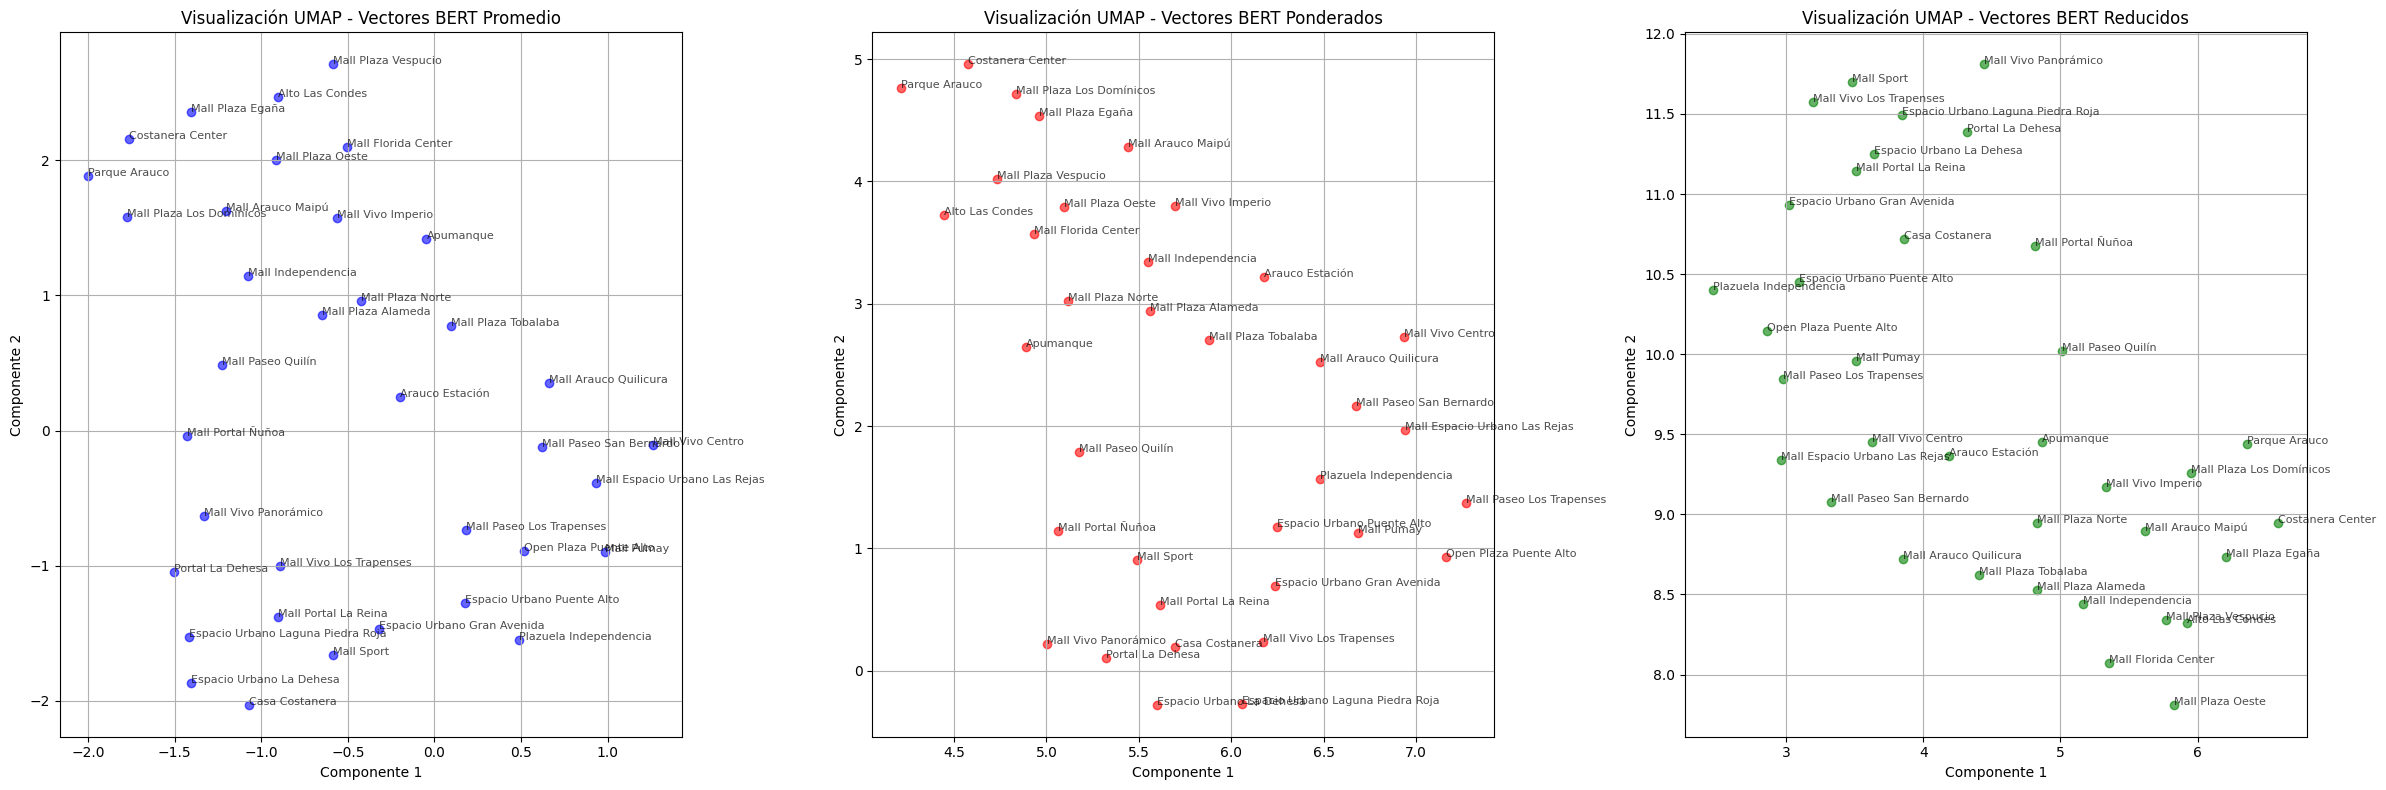

In [ ]:
# Obtener los vectores para cada tipo
vectores_bert_promedio = np.array(resultados_bert['vector_bert_prom'].tolist())
vectores_bert_ponderado = np.array(resultados_bert['vector_bert_ponderado'].tolist())
vectores_bert_reducido = np.array(resultados_bert['vector_bert_reducido'].tolist())

# Aplicar UMAP para reducir la dimensionalidad a 2D
umap_bert_promedio = umap.UMAP(n_components=2, random_state=42).fit_transform(vectores_bert_promedio)
umap_bert_ponderado = umap.UMAP(n_components=2, random_state=42).fit_transform(vectores_bert_ponderado)
umap_bert_reducido = umap.UMAP(n_components=2, random_state=42).fit_transform(vectores_bert_reducido)

# Crear gráficos de dispersión
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Graficar UMAP para vectores BERT promedio
scatter_promedio = axs[0].scatter(umap_bert_promedio[:, 0], umap_bert_promedio[:, 1], c='blue', alpha=0.6)
axs[0].set_title('Visualización UMAP - Vectores BERT Promedio')
axs[0].set_xlabel('Componente 1')
axs[0].set_ylabel('Componente 2')
axs[0].grid(True)

# Añadir etiquetas con el nombre del centro comercial en el gráfico promedio
for i, centro in enumerate(resultados_bert['Centro Comercial']):
    axs[0].annotate(centro, (umap_bert_promedio[i, 0], umap_bert_promedio[i, 1]), fontsize=8, alpha=0.7)

# Graficar UMAP para vectores BERT ponderados
scatter_ponderado = axs[1].scatter(umap_bert_ponderado[:, 0], umap_bert_ponderado[:, 1], c='red', alpha=0.6)
axs[1].set_title('Visualización UMAP - Vectores BERT Ponderados')
axs[1].set_xlabel('Componente 1')
axs[1].set_ylabel('Componente 2')
axs[1].grid(True)

# Añadir etiquetas con el nombre del centro comercial en el gráfico ponderado
for i, centro in enumerate(resultados_bert['Centro Comercial']):
    axs[1].annotate(centro, (umap_bert_ponderado[i, 0], umap_bert_ponderado[i, 1]), fontsize=8, alpha=0.7)

# Graficar UMAP para vectores BERT reducidos
scatter_reducido = axs[2].scatter(umap_bert_reducido[:, 0], umap_bert_reducido[:, 1], c='green', alpha=0.6)
axs[2].set_title('Visualización UMAP - Vectores BERT Reducidos')
axs[2].set_xlabel('Componente 1')
axs[2].set_ylabel('Componente 2')
axs[2].grid(True)

# Añadir etiquetas con el nombre del centro comercial en el gráfico reducido
for i, centro in enumerate(resultados_bert['Centro Comercial']):
    axs[2].annotate(centro, (umap_bert_reducido[i, 0], umap_bert_reducido[i, 1]), fontsize=8, alpha=0.7)



plt.tight_layout()
plt.show()


#### Clúster

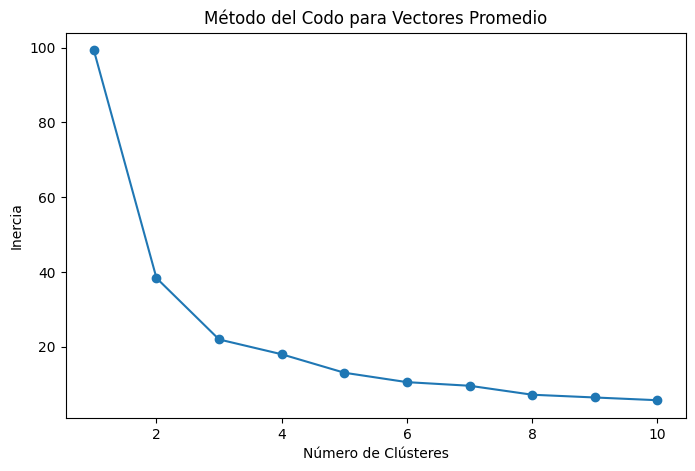

In [ ]:
from sklearn.cluster import KMeans

# Determinar el número óptimo de clústeres usando el método del codo
inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(umap_bert_promedio)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del Codo para Vectores Promedio')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inercia')
plt.show()

In [ ]:
# Aplicar K-Means a los vectores BERT promedio
kmeans_promedio = KMeans(n_clusters=5, random_state=42)
clusters_promedio = kmeans_promedio.fit_predict(vectores_bert_promedio)

# Aplicar K-Means a los vectores BERT ponderados
kmeans_ponderado = KMeans(n_clusters=5, random_state=42)
clusters_ponderado = kmeans_ponderado.fit_predict(vectores_bert_ponderado)

# Aplicar K-Means a los vectores BERT reducidos
kmeans_reducido = KMeans(n_clusters=5, random_state=42)
clusters_reducido = kmeans_reducido.fit_predict(vectores_bert_reducido)

# Agregar los clústeres al DataFrame resultados_bert
resultados_bert['Cluster_Promedio'] = clusters_promedio
resultados_bert['Cluster_Ponderado'] = clusters_ponderado
resultados_bert['Cluster_Reducido'] = clusters_reducido

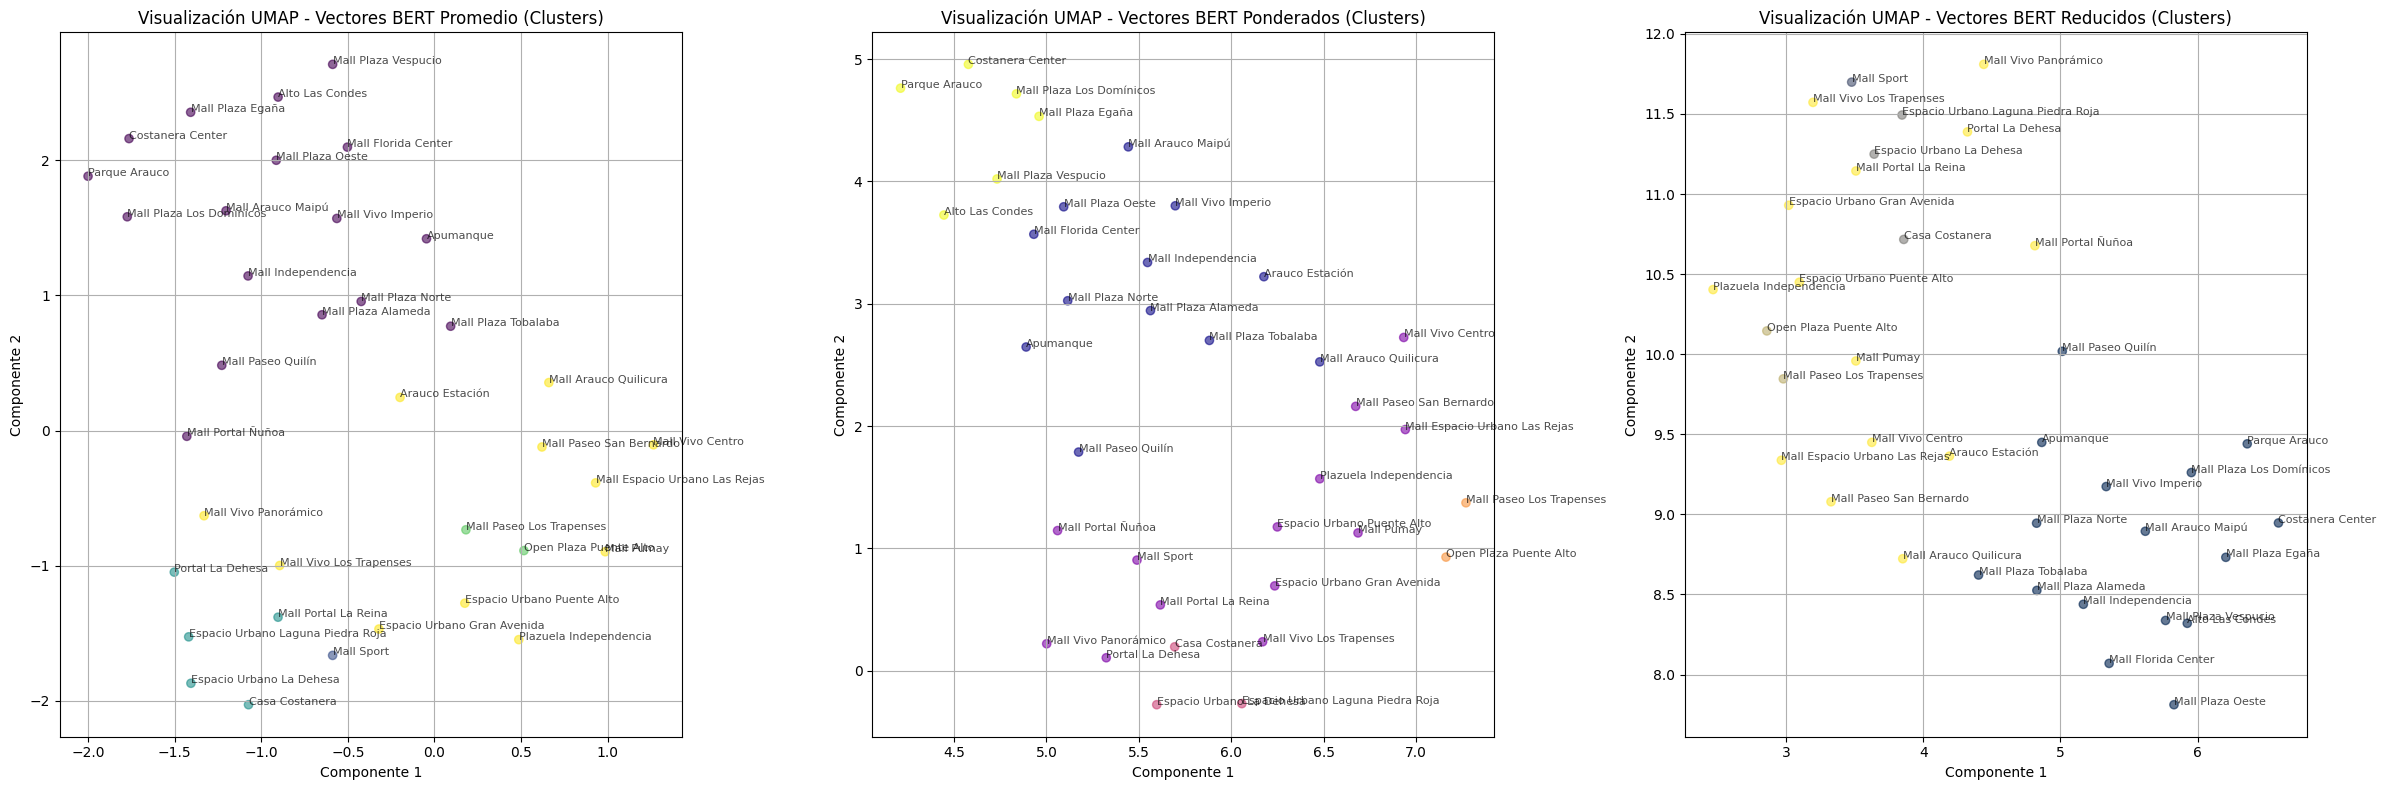

In [ ]:
import matplotlib.pyplot as plt
import umap
import numpy as np

# Crear gráficos de dispersión para los vectores BERT con clusters
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Graficar UMAP para vectores BERT promedio con clusters
scatter_promedio = axs[0].scatter(umap_bert_promedio[:, 0], umap_bert_promedio[:, 1], c=clusters_promedio, cmap='viridis', alpha=0.6)
axs[0].set_title('Visualización UMAP - Vectores BERT Promedio (Clusters)')
axs[0].set_xlabel('Componente 1')
axs[0].set_ylabel('Componente 2')
axs[0].grid(True)

# Añadir etiquetas con el nombre del centro comercial en el gráfico promedio
for i, centro in enumerate(resultados_bert['Centro Comercial']):
    axs[0].annotate(centro, (umap_bert_promedio[i, 0], umap_bert_promedio[i, 1]), fontsize=8, alpha=0.7)

# Graficar UMAP para vectores BERT ponderados con clusters
scatter_ponderado = axs[1].scatter(umap_bert_ponderado[:, 0], umap_bert_ponderado[:, 1], c=clusters_ponderado, cmap='plasma', alpha=0.6)
axs[1].set_title('Visualización UMAP - Vectores BERT Ponderados (Clusters)')
axs[1].set_xlabel('Componente 1')
axs[1].set_ylabel('Componente 2')
axs[1].grid(True)

# Añadir etiquetas con el nombre del centro comercial en el gráfico ponderado
for i, centro in enumerate(resultados_bert['Centro Comercial']):
    axs[1].annotate(centro, (umap_bert_ponderado[i, 0], umap_bert_ponderado[i, 1]), fontsize=8, alpha=0.7)

# Graficar UMAP para vectores BERT reducidos con clusters
scatter_reducido = axs[2].scatter(umap_bert_reducido[:, 0], umap_bert_reducido[:, 1], c=clusters_reducido, cmap='cividis', alpha=0.6)
axs[2].set_title('Visualización UMAP - Vectores BERT Reducidos (Clusters)')
axs[2].set_xlabel('Componente 1')
axs[2].set_ylabel('Componente 2')
axs[2].grid(True)

# Añadir etiquetas con el nombre del centro comercial en el gráfico reducido
for i, centro in enumerate(resultados_bert['Centro Comercial']):
    axs[2].annotate(centro, (umap_bert_reducido[i, 0], umap_bert_reducido[i, 1]), fontsize=8, alpha=0.7)

# Ajustar el diseño de los gráficos
plt.tight_layout()


plt.show()


#### Gráfico Correlación

## Tópicos

In [ ]:
# Función de limpieza para eliminar stop_words personalizadas
def Limpieza_texto(texto, stop_words):
    doc = nlp(texto)
    palabras_limpias = [token.text for token in doc if token.text not in stop_words and len(token.text) > 1]  # Sin lematización
    return ' '.join(palabras_limpias)

# Aplicar la función a un DataFrame (df_resenas)
df_resenas['reseña_limpia'] = df_resenas['Reseña'].apply(lambda x: Limpieza_texto(x, stop_words))  # Eliminar stop_words

In [ ]:
df_agrupado = df_resenas.groupby('Centro Comercial')['Reseña'].apply(lambda x: ' '.join(x)).reset_index()


In [ ]:
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

np.random.seed(42)
random.seed(42)

# Lista para almacenar los tópicos de cada centro comercial
topics_per_mall = {}

# Iterar sobre cada centro comercial
for index, row in df_agrupado.iterrows():
    # Supongamos que cada reseña está separada por un punto
    reseñas = row['Reseña'].split('. ')  # Separa las reseñas por oración o manténlas como están

    # Define los modelos UMAP y HDBSCAN
    umap_model = UMAP(n_components=2)
    hdbscan_model = HDBSCAN(min_samples=4)

    # Aplica BERTopic con los modelos especificados
    topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, language="multilingual")
    topics, probabilities = topic_model.fit_transform(reseñas)

    # Guarda los tópicos en el diccionario
    topics_info = topic_model.get_topic_info()
    topics_per_mall[row['Centro Comercial']] = topics_info  # Guarda el DataFrame de tópicos

# Crear una lista para almacenar todos los DataFrames
all_topics_dfs = []

# Itera sobre cada centro comercial y añade los DataFrames a la lista
for mall, topics_info in topics_per_mall.items():
    topics_info['Centro Comercial'] = mall  # Añade una columna con el nombre del centro comercial
    all_topics_dfs.append(topics_info)

# Concatena todos los DataFrames en uno solo
all_topics_df = pd.concat(all_topics_dfs, ignore_index=True)


In [ ]:
all_topics_df[all_topics_df['Centro Comercial'] == 'Parque Arauco']


,Topic,Count,Name,Representation,Representative_Docs,Centro Comercial
181,-1,1,-1_conocerlo_vale_pena_la,"[conocerlo, vale, pena, la, , , , , , ]",[Vale la pena conocerlo],Parque Arauco
182,0,188,0_de_para_es_con,"[de, para, es, con, que, la, el, en, un, muy]",[Lo único que podría mejorar son las indicacio...,Parque Arauco
183,1,14,1_de_santiago_el_en,"[de, santiago, el, en, con, mall, chile, mejor...",[El único centro comercial que me gusta de San...,Parque Arauco
184,2,7,2_no_camioneta_lavado_que,"[no, camioneta, lavado, que, la, el, se, ecodr...",[(Varios de los empleados de Tesla que trabaja...,Parque Arauco


## Modelos de visita

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Se une todo en un dataframe para cada modelo, es decir, se tiene uno para fasttext, Bert, 

In [ ]:
# Merge df with 'vector_promedio' and 'vector_ponderado' from 'resultados'
df_malls_fttx = pd.merge(df, resultados_fttx[['Centro Comercial', 'vector_promedio', 'vector_ponderado','Cluster_Promedio', 'Cluster_Ponderado']], # Cambiar a vector_fasttext
                    left_on='MALL_NAME', right_on='Centro Comercial', how='left')

# Eliminar la columna 'Centro Comercial' si no es necesaria
df_malls_fttx.drop(['Centro Comercial'], axis=1, inplace=True)

# Remover Espacio Urbano La Reina porque no hay reseñas
df_malls_fttx = df_malls_fttx[df_malls_fttx['MALL_NAME'] != 'Espacio Urbano La Reina']

# Convertir 'vector_promedio' en columnas separadas
vector_columns_prom = pd.DataFrame(df_malls_fttx['vector_promedio'].tolist(), index=df_malls_fttx.index)
vector_columns_prom.columns = [f"vector_promedio_{i}" for i in range(vector_columns_prom.shape[1])]

# Convertir 'vector_ponderado' en columnas separadas
vector_columns_pond = pd.DataFrame(df_malls_fttx['vector_ponderado'].tolist(), index=df_malls_fttx.index)
vector_columns_pond.columns = [f"vector_ponderado_{i}" for i in range(vector_columns_pond.shape[1])]

# Añadir las columnas expandidas al DataFrame original
df_malls_fttx_expanded = pd.concat([df_malls_fttx.drop(columns=['vector_promedio', 'vector_ponderado']), 
                               vector_columns_prom, vector_columns_pond], axis=1)


In [ ]:
# Merge df_malls with 'vector_bert' and 'vector_ponderado' from 'resultados'
df_malls_bert = pd.merge(df, resultados_bert[['Centro Comercial', 'vector_bert_prom', 'vector_bert_ponderado', 'vector_bert_reducido', 'Cluster_Promedio', 'Cluster_Ponderado', 'Cluster_Reducido']],
                    left_on='MALL_NAME', right_on='Centro Comercial', how='left')

# Eliminar la columna 'Centro Comercial' si no es necesaria
df_malls_bert.drop(['Centro Comercial'], axis=1, inplace=True)

# Remover espacios no deseados 
df_malls_bert = df_malls_bert[df_malls_bert['MALL_NAME'] != 'Espacio Urbano La Reina']

# Convertir 'vector_bert' en columnas separadas
vector_bert_prom = pd.DataFrame(df_malls_bert['vector_bert_prom'].tolist(), index=df_malls_bert.index)
vector_bert_prom.columns = [f"vector_bert_prom{i}" for i in range(vector_bert_prom.shape[1])]

# Convertir 'vector_bert_ponderado' en columnas separadas
vector_bert_pond = pd.DataFrame(df_malls_bert['vector_bert_ponderado'].tolist(), index=df_malls_bert.index)
vector_bert_pond.columns = [f"vector_bert_ponderado{i}" for i in range(vector_bert_pond.shape[1])]

# Convertir 'vector_reducido' en columnas separadas
vector_bert_reducido = pd.DataFrame(df_malls_bert['vector_bert_reducido'].tolist(), index=df_malls_bert.index)
vector_bert_reducido.columns = [f"vector_reducido_{i}" for i in range(vector_bert_reducido.shape[1])]

# Añadir las columnas expandidas al DataFrame original
df_malls_bert_expanded = pd.concat([df_malls_bert.drop(columns=['vector_bert_prom', 'vector_bert_ponderado', 'vector_bert_reducido']),
                               vector_bert_prom, vector_bert_pond, vector_bert_reducido], axis=1)

#Resetear el índice
df_malls_bert_expanded.reset_index(drop=True, inplace=True)

Baseline

In [ ]:
# Seleccionar columnas sin vectores
columnas_sin_vectores = ["PROBABILITY", "NUM_TIENDAS", "SUPERFICIE_M2",
                         "NUM_TIENDAS_ANCLAS", "N_FARMACIAS", "N_SUPER", "N_CAFETERIA", 
                         "N_RESTAURANTES", "N_BELLEZA", "DISTANCIA_T.PUBLICO", "TIEMPO_AUTO", 
                         "NUM_RECORRIDOS_BUS", "DIST_MALL_METRO", "PERSONAS", "HOMBRES", 
                         "INDICE_HOGAR_ismt","MALL_NAME","NOM_COMUNA"]

# Filtrar el DataFrame sin vectores
df_baseline = df_malls_fttx_expanded[columnas_sin_vectores].dropna()


fasttext con vectores promediados

In [ ]:
# Seleccionar columnas sin vectores
columnas_fttx_prom = ["PROBABILITY", "NUM_TIENDAS", "SUPERFICIE_M2",
                         "NUM_TIENDAS_ANCLAS", "N_FARMACIAS", "N_SUPER", "N_CAFETERIA", 
                         "N_RESTAURANTES", "N_BELLEZA", "DISTANCIA_T.PUBLICO", "TIEMPO_AUTO", 
                         "NUM_RECORRIDOS_BUS", "DIST_MALL_METRO", "PERSONAS", "HOMBRES", 
                         "INDICE_HOGAR_ismt","MALL_NAME","NOM_COMUNA"] + \
                         [f"vector_promedio_{i}" for i in range(vector_columns_prom.shape[1])]

# Filtrar el DataFrame sin vectores
df_ft_prom = df_malls_fttx_expanded[columnas_fttx_prom].dropna()


fasttext con vectores ponderados

In [ ]:
# Seleccionar columnas sin vectores
columnas_vect_pond = ["PROBABILITY", "NUM_TIENDAS", "SUPERFICIE_M2",
                         "NUM_TIENDAS_ANCLAS", "N_FARMACIAS", "N_SUPER", "N_CAFETERIA", 
                         "N_RESTAURANTES", "N_BELLEZA", "DISTANCIA_T.PUBLICO", "TIEMPO_AUTO", 
                         "NUM_RECORRIDOS_BUS", "DIST_MALL_METRO", "PERSONAS", "HOMBRES", 
                         "INDICE_HOGAR_ismt","MALL_NAME","NOM_COMUNA"] + \
                         [f"vector_ponderado_{i}" for i in range(vector_columns_pond.shape[1])]

# Filtrar el DataFrame sin vectores
df_ft_pond = df_malls_fttx_expanded[columnas_vect_pond].dropna()

Fasttext promedio con clústers

In [ ]:
# Columnas sin los vectores
columnas_fttx_prom_cluster = ["PROBABILITY", "NUM_TIENDAS", "SUPERFICIE_M2",
                         "NUM_TIENDAS_ANCLAS", "N_FARMACIAS", "N_SUPER", "N_CAFETERIA", 
                         "N_RESTAURANTES", "N_BELLEZA", "DISTANCIA_T.PUBLICO", "TIEMPO_AUTO", 
                         "NUM_RECORRIDOS_BUS", "DIST_MALL_METRO", "PERSONAS", "HOMBRES", 
                         "INDICE_HOGAR_ismt", "MALL_NAME", "NOM_COMUNA", "Cluster_Promedio"]

df_ft_prom_cluster = df_malls_fttx_expanded[columnas_fttx_prom_cluster].dropna()

# Crear el One-Hot Encoding para los clusters
df_ft_prom_cluster = pd.get_dummies(df_ft_prom_cluster, columns=["Cluster_Promedio"], prefix=["ClusterProm"])

# Filtrar las columnas booleanas
boolean_columns = df_ft_prom_cluster.select_dtypes(include=['bool']).columns

# Convertir solo las columnas booleanas a int
df_ft_prom_cluster[boolean_columns] = df_ft_prom_cluster[boolean_columns].astype(int)


Fasttext ponderado con clústers

In [ ]:
# Columnas sin los vectores
columnas_fttx_pond_cluster = ["PROBABILITY", "NUM_TIENDAS", "SUPERFICIE_M2",
                         "NUM_TIENDAS_ANCLAS", "N_FARMACIAS", "N_SUPER", "N_CAFETERIA", 
                         "N_RESTAURANTES", "N_BELLEZA", "DISTANCIA_T.PUBLICO", "TIEMPO_AUTO", 
                         "NUM_RECORRIDOS_BUS", "DIST_MALL_METRO", "PERSONAS", "HOMBRES", 
                         "INDICE_HOGAR_ismt", "MALL_NAME", "NOM_COMUNA", "Cluster_Ponderado"]

df_ft_pond_cluster = df_malls_fttx_expanded[columnas_fttx_pond_cluster].dropna()

# Crear el One-Hot Encoding para los clusters
df_ft_pond_cluster = pd.get_dummies(df_ft_pond_cluster, columns=["Cluster_Ponderado"], prefix=["ClusterPond"])

# Filtrar las columnas booleanas
boolean_columns = df_ft_pond_cluster.select_dtypes(include=['bool']).columns

# Convertir solo las columnas booleanas a int
df_ft_pond_cluster[boolean_columns] = df_ft_pond_cluster[boolean_columns].astype(int)


BERT con vectores promedio

In [ ]:
# Seleccionar columnas sin vectores
columnas_bert_prom = ["PROBABILITY", "NUM_TIENDAS", "SUPERFICIE_M2",
                         "NUM_TIENDAS_ANCLAS", "N_FARMACIAS", "N_SUPER", "N_CAFETERIA", 
                         "N_RESTAURANTES", "N_BELLEZA", "DISTANCIA_T.PUBLICO", "TIEMPO_AUTO", 
                         "NUM_RECORRIDOS_BUS", "DIST_MALL_METRO", "PERSONAS", "HOMBRES", 
                         "INDICE_HOGAR_ismt","MALL_NAME","NOM_COMUNA"] + \
                         [f"vector_bert_prom{i}" for i in range(vector_bert_prom.shape[1])]

# Filtrar el DataFrame sin vectores
df_bert_prom = df_malls_bert_expanded[columnas_bert_prom].dropna()


BERT con vectores ponderados

In [ ]:
# Seleccionar columnas sin vectores
columnas_bert_pond = ["PROBABILITY", "NUM_TIENDAS", "SUPERFICIE_M2",
                         "NUM_TIENDAS_ANCLAS", "N_FARMACIAS", "N_SUPER", "N_CAFETERIA", 
                         "N_RESTAURANTES", "N_BELLEZA", "DISTANCIA_T.PUBLICO", "TIEMPO_AUTO", 
                         "NUM_RECORRIDOS_BUS", "DIST_MALL_METRO", "PERSONAS", "HOMBRES", 
                         "INDICE_HOGAR_ismt","MALL_NAME","NOM_COMUNA"] + \
                         [f"vector_bert_ponderado{i}" for i in range(vectores_bert_ponderado.shape[1])]

# Filtrar el DataFrame sin vectores
df_bert_pond = df_malls_bert_expanded[columnas_bert_pond].dropna()


BERT con vectores reducidos

In [ ]:
# Seleccionar columnas sin vectores
columnas_bert_reducido = ["PROBABILITY", "NUM_TIENDAS", "SUPERFICIE_M2",
                         "NUM_TIENDAS_ANCLAS", "N_FARMACIAS", "N_SUPER", "N_CAFETERIA", 
                         "N_RESTAURANTES", "N_BELLEZA", "DISTANCIA_T.PUBLICO", "TIEMPO_AUTO", 
                         "NUM_RECORRIDOS_BUS", "DIST_MALL_METRO", "PERSONAS", "HOMBRES", 
                         "INDICE_HOGAR_ismt","MALL_NAME","NOM_COMUNA"] + \
                         [f"vector_reducido_{i}" for i in range(vector_bert_reducido.shape[1])]

# Filtrar el DataFrame sin vectores
df_bert_reducido = df_malls_bert_expanded[columnas_bert_reducido].dropna()

BERT promedio con clúster

In [ ]:
# Columnas sin los vectores
columnas_bert_prom_cluster = ["PROBABILITY", "NUM_TIENDAS", "SUPERFICIE_M2",
                         "NUM_TIENDAS_ANCLAS", "N_FARMACIAS", "N_SUPER", "N_CAFETERIA", 
                         "N_RESTAURANTES", "N_BELLEZA", "DISTANCIA_T.PUBLICO", "TIEMPO_AUTO", 
                         "NUM_RECORRIDOS_BUS", "DIST_MALL_METRO", "PERSONAS", "HOMBRES", 
                         "INDICE_HOGAR_ismt", "MALL_NAME", "NOM_COMUNA", "Cluster_Promedio"]

df_bert_prom_cluster = df_malls_bert_expanded[columnas_bert_prom_cluster].dropna()

# Crear el One-Hot Encoding para los clusters
df_bert_prom_cluster = pd.get_dummies(df_bert_prom_cluster, columns=["Cluster_Promedio"], prefix=["ClusterProm"])

# Filtrar las columnas booleanas
boolean_columns = df_bert_prom_cluster.select_dtypes(include=['bool']).columns

# Convertir solo las columnas booleanas a int
df_bert_prom_cluster[boolean_columns] = df_bert_prom_cluster[boolean_columns].astype(int)

BERT ponderado con clúster

In [ ]:
# Columnas sin los vectores
columnas_bert_pond_cluster = ["PROBABILITY", "NUM_TIENDAS", "SUPERFICIE_M2",
                         "NUM_TIENDAS_ANCLAS", "N_FARMACIAS", "N_SUPER", "N_CAFETERIA", 
                         "N_RESTAURANTES", "N_BELLEZA", "DISTANCIA_T.PUBLICO", "TIEMPO_AUTO", 
                         "NUM_RECORRIDOS_BUS", "DIST_MALL_METRO", "PERSONAS", "HOMBRES", 
                         "INDICE_HOGAR_ismt", "MALL_NAME", "NOM_COMUNA", "Cluster_Ponderado"]

df_bert_pond_cluster = df_malls_bert_expanded[columnas_bert_pond_cluster].dropna()

# Crear el One-Hot Encoding para los clusters
df_bert_pond_cluster = pd.get_dummies(df_bert_pond_cluster, columns=["Cluster_Ponderado"], prefix=["Clusterpond"])

# Filtrar las columnas booleanas
boolean_columns = df_bert_pond_cluster.select_dtypes(include=['bool']).columns

# Convertir solo las columnas booleanas a int
df_bert_pond_cluster[boolean_columns] = df_bert_pond_cluster[boolean_columns].astype(int)

BERT reducido con clúster

In [ ]:
# Columnas sin los vectores
columnas_bert_reduc_cluster = ["PROBABILITY", "NUM_TIENDAS", "SUPERFICIE_M2",
                         "NUM_TIENDAS_ANCLAS", "N_FARMACIAS", "N_SUPER", "N_CAFETERIA", 
                         "N_RESTAURANTES", "N_BELLEZA", "DISTANCIA_T.PUBLICO", "TIEMPO_AUTO", 
                         "NUM_RECORRIDOS_BUS", "DIST_MALL_METRO", "PERSONAS", "HOMBRES", 
                         "INDICE_HOGAR_ismt", "MALL_NAME", "NOM_COMUNA", "Cluster_Reducido"]

df_bert_reduc_cluster = df_malls_bert_expanded[columnas_bert_reduc_cluster].dropna()

# Crear el One-Hot Encoding para los clusters
df_bert_reduc_cluster = pd.get_dummies(df_bert_reduc_cluster, columns=["Cluster_Reducido"], prefix=["ClusteReduc"])

# Filtrar las columnas booleanas
boolean_columns = df_bert_reduc_cluster.select_dtypes(include=['bool']).columns

# Convertir solo las columnas booleanas a int
df_bert_reduc_cluster[boolean_columns] = df_bert_reduc_cluster[boolean_columns].astype(int)

### Random forest

#### Baseline

In [ ]:
X = df_baseline.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_baseline["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

rf_baseline = RandomForestRegressor(n_estimators=300, max_features=3, random_state=123)
rf_baseline.fit(X_train, y_train)

importancia_variables_rf_baseline = rf_baseline.feature_importances_

tabla_importancia_rf_baseline = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_rf_baseline
})

tabla_importancia_rf_baseline = tabla_importancia_rf_baseline.sort_values(by="Importancia", ascending=False)

In [ ]:
tabla_importancia_rf_baseline.head(15)

,Variable,Importancia
8,DISTANCIA_T.PUBLICO,0.208595
9,TIEMPO_AUTO,0.186892
13,HOMBRES,0.138481
12,PERSONAS,0.133723
14,INDICE_HOGAR_ismt,0.059750
4,N_SUPER,0.052758
0,NUM_TIENDAS,0.047751
1,SUPERFICIE_M2,0.045545
7,N_BELLEZA,0.034356
2,NUM_TIENDAS_ANCLAS,0.022640


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = rf_baseline.predict(X_test)

# Calcular R^2 y RMSE
r2_rf_1 = r2_score(y_test, y_pred)
rmse_rf_1 = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_rf_1:.4f}')
print(f'RMSE: {rmse_rf_1:.4f}')


R^2: 0.5114
RMSE: 0.0574


#### Fasttext Vector promedio

In [ ]:
X = df_ft_prom.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_ft_prom["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
rf_ft_prom = RandomForestRegressor(n_estimators=300, max_features=3, random_state=123)
rf_ft_prom.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_ft_prom = rf_ft_prom.feature_importances_

# Crear la tabla de importancia
tabla_importancia_ft_prom = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_ft_prom
})

tabla_importancia_ft_prom = tabla_importancia_ft_prom.sort_values(by="Importancia", ascending=False)



In [ ]:
tabla_importancia_ft_prom.head(15)


,Variable,Importancia
8,DISTANCIA_T.PUBLICO,0.215487
9,TIEMPO_AUTO,0.184732
13,HOMBRES,0.134578
12,PERSONAS,0.130509
14,INDICE_HOGAR_ismt,0.075763
4,N_SUPER,0.066428
7,N_BELLEZA,0.047458
6,N_RESTAURANTES,0.023111
3,N_FARMACIAS,0.012960
5,N_CAFETERIA,0.009643


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = rf_ft_prom.predict(X_test)

# Calcular R^2 y RMSE
r2_rf_2 = r2_score(y_test, y_pred)
rmse_rf_2 = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_rf_2:.4f}')
print(f'RMSE: {rmse_rf_2:.4f}')


R^2: 0.5197
RMSE: 0.0569


#### Fasttext Vector Ponderado

In [ ]:
X = df_ft_pond.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_ft_pond["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
rf_ft_pond = RandomForestRegressor(n_estimators=300, max_features=3, random_state=123)
rf_ft_pond.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_ft_pond = rf_ft_pond.feature_importances_

# Crear la tabla de importancia
tabla_importancia_ft_pond = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_ft_pond
})

tabla_importancia_ft_pond = tabla_importancia_ft_pond.sort_values(by="Importancia", ascending=False)


In [ ]:
tabla_importancia_ft_pond.head(15)

,Variable,Importancia
8,DISTANCIA_T.PUBLICO,0.217929
9,TIEMPO_AUTO,0.181844
13,HOMBRES,0.134486
12,PERSONAS,0.130770
14,INDICE_HOGAR_ismt,0.075831
4,N_SUPER,0.066107
7,N_BELLEZA,0.047676
6,N_RESTAURANTES,0.022528
3,N_FARMACIAS,0.012510
5,N_CAFETERIA,0.010012


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = rf_ft_pond.predict(X_test)

# Calcular R^2 y RMSE
r2_rf_3 = r2_score(y_test, y_pred)
rmse_rf_3 = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_rf_3:.4f}')
print(f'RMSE: {rmse_rf_3:.4f}')


R^2: 0.5194
RMSE: 0.0569


#### Fasttext promedio con Clúster

In [ ]:
X = df_ft_prom_cluster.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_ft_prom_cluster["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
rf_ft_prom_clust = RandomForestRegressor(n_estimators=300, max_features=3, random_state=123)
rf_ft_prom_clust.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_ft_prom_clust = rf_ft_prom_clust.feature_importances_

# Crear la tabla de importancia
tabla_importancia_ft_prom_clust = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_ft_prom_clust
})

tabla_importancia_ft_prom_clust = tabla_importancia_ft_prom_clust.sort_values(by="Importancia", ascending=False)

In [ ]:
tabla_importancia_ft_prom_clust.head(15)

,Variable,Importancia
8,DISTANCIA_T.PUBLICO,0.207559
9,TIEMPO_AUTO,0.187081
13,HOMBRES,0.138476
12,PERSONAS,0.133479
14,INDICE_HOGAR_ismt,0.061955
4,N_SUPER,0.055512
0,NUM_TIENDAS,0.039238
7,N_BELLEZA,0.036852
1,SUPERFICIE_M2,0.034942
2,NUM_TIENDAS_ANCLAS,0.020558


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = rf_ft_prom_clust.predict(X_test)

# Calcular R^2 y RMSE
r2_rf_fttx_prom_clust = r2_score(y_test, y_pred)
rmse_rf_fttx_prom_clust = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_rf_fttx_prom_clust:.4f}')
print(f'RMSE: {rmse_rf_fttx_prom_clust:.4f}')

R^2: 0.5129
RMSE: 0.0573


#### Fasttext ponderado con Clúster

In [ ]:
X = df_ft_pond_cluster.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_ft_pond_cluster["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
rf_ft_pond_clust = RandomForestRegressor(n_estimators=300, max_features=3, random_state=123)
rf_ft_pond_clust.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_ft_pond_clust = rf_ft_pond_clust.feature_importances_

# Crear la tabla de importancia
tabla_importancia_ft_pond_clust = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_ft_pond_clust
})

tabla_importancia_ft_pond_clust = tabla_importancia_ft_pond_clust.sort_values(by="Importancia", ascending=False)

tabla_importancia_ft_pond_clust.head(15)

,Variable,Importancia
8,DISTANCIA_T.PUBLICO,0.209850
9,TIEMPO_AUTO,0.185616
13,HOMBRES,0.138421
12,PERSONAS,0.133876
14,INDICE_HOGAR_ismt,0.061132
4,N_SUPER,0.055054
0,NUM_TIENDAS,0.041207
1,SUPERFICIE_M2,0.037388
7,N_BELLEZA,0.035949
2,NUM_TIENDAS_ANCLAS,0.022279


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = rf_ft_pond_clust.predict(X_test)

# Calcular R^2 y RMSE
r2_rf_fttx_pond_clust = r2_score(y_test, y_pred)
rmse_rf_fttx_pond_clust = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_rf_fttx_pond_clust:.4f}')
print(f'RMSE: {rmse_rf_fttx_pond_clust:.4f}')

R^2: 0.5129
RMSE: 0.0573


#### BERT Vector promedio

In [ ]:
X = df_bert_prom.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_bert_prom["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
rf_bert_prom = RandomForestRegressor(n_estimators=300, max_features=3, random_state=123)
rf_bert_prom.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_bert_prom = rf_bert_prom.feature_importances_

# Crear la tabla de importancia
tabla_importancia_bert_prom = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_bert_prom
})

tabla_importancia_bert_prom = tabla_importancia_bert_prom.sort_values(by="Importancia", ascending=False)

In [ ]:
tabla_importancia_bert_prom.head(15)

,Variable,Importancia
8,DISTANCIA_T.PUBLICO,0.217624
9,TIEMPO_AUTO,0.185689
13,HOMBRES,0.134163
12,PERSONAS,0.130365
14,INDICE_HOGAR_ismt,0.078060
4,N_SUPER,0.068326
7,N_BELLEZA,0.049686
6,N_RESTAURANTES,0.023681
3,N_FARMACIAS,0.013451
5,N_CAFETERIA,0.011280


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = rf_bert_prom.predict(X_test)

# Calcular R^2 y RMSE
r2_rf_bert_prom = r2_score(y_test, y_pred)
rmse_rf_bert_prom = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_rf_bert_prom:.4f}')
print(f'RMSE: {rmse_rf_bert_prom:.4f}')


R^2: 0.5201
RMSE: 0.0569


#### BERT Vector ponderado

In [ ]:
X = df_bert_pond.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_bert_pond["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
rf_bert_pond = RandomForestRegressor(n_estimators=300, max_features=3, random_state=123)
rf_bert_pond.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_bert_pond = rf_bert_pond.feature_importances_

# Crear la tabla de importancia
tabla_importancia_bert_pond = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_bert_pond
})

tabla_importancia_bert_pond = tabla_importancia_bert_pond.sort_values(by="Importancia", ascending=False)

In [ ]:
tabla_importancia_bert_pond.head(15)

,Variable,Importancia
8,DISTANCIA_T.PUBLICO,0.215065
9,TIEMPO_AUTO,0.188371
13,HOMBRES,0.134053
12,PERSONAS,0.130199
14,INDICE_HOGAR_ismt,0.078727
4,N_SUPER,0.067995
7,N_BELLEZA,0.049103
6,N_RESTAURANTES,0.024577
3,N_FARMACIAS,0.013291
5,N_CAFETERIA,0.011238


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = rf_bert_pond.predict(X_test)

# Calcular R^2 y RMSE
r2_rf_bert_pond = r2_score(y_test, y_pred)
rmse_rf_bert_pond = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_rf_bert_pond:.4f}')
print(f'RMSE: {rmse_rf_bert_pond:.4f}')


R^2: 0.5202
RMSE: 0.0568


#### BERT Vector reducido


In [ ]:
X = df_bert_reducido.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_bert_reducido["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
rf_bert_reducido = RandomForestRegressor(n_estimators=300, max_features=3, random_state=123)
rf_bert_reducido.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_bert_reducido = rf_bert_reducido.feature_importances_

# Crear la tabla de importancia
tabla_importancia_bert_reducido = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_bert_reducido
})

tabla_importancia_bert_reducido = tabla_importancia_bert_reducido.sort_values(by="Importancia", ascending=False)

In [ ]:
tabla_importancia_bert_reducido.head(15)

,Variable,Importancia
8,DISTANCIA_T.PUBLICO,0.210617
9,TIEMPO_AUTO,0.191324
13,HOMBRES,0.134645
12,PERSONAS,0.130599
14,INDICE_HOGAR_ismt,0.074966
4,N_SUPER,0.066042
7,N_BELLEZA,0.047275
6,N_RESTAURANTES,0.022180
3,N_FARMACIAS,0.012626
5,N_CAFETERIA,0.009314


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = rf_bert_reducido.predict(X_test)

# Calcular R^2 y RMSE
r2_rf_bert_reducido = r2_score(y_test, y_pred)
rmse_rf_bert_reducido = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_rf_bert_reducido:.4f}')
print(f'RMSE: {rmse_rf_bert_reducido:.4f}')

R^2: 0.5195
RMSE: 0.0569


#### BERT Promedio Clúster

In [ ]:
X = df_bert_prom_cluster.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_bert_prom_cluster["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
rf_bert_prom_cluster = RandomForestRegressor(n_estimators=300, max_features=3, random_state=123)
rf_bert_prom_cluster.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_bert_prom_cluster = rf_bert_prom_cluster.feature_importances_

# Crear la tabla de importancia
tabla_importancia_bert_prom_cluster = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_bert_prom_cluster
})

tabla_importancia_bert_prom_cluster = tabla_importancia_bert_prom_cluster.sort_values(by="Importancia", ascending=False)

In [ ]:
tabla_importancia_bert_prom_cluster.head(15)

,Variable,Importancia
8,DISTANCIA_T.PUBLICO,0.210930
9,TIEMPO_AUTO,0.183849
13,HOMBRES,0.137871
12,PERSONAS,0.133270
14,INDICE_HOGAR_ismt,0.061862
4,N_SUPER,0.054833
0,NUM_TIENDAS,0.043503
7,N_BELLEZA,0.036658
1,SUPERFICIE_M2,0.036367
2,NUM_TIENDAS_ANCLAS,0.021316


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = rf_bert_prom_cluster.predict(X_test)

# Calcular R^2 y RMSE
r2_rf_bert_prom_cluster = r2_score(y_test, y_pred)
rmse_rf_bert_prom_cluster = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_rf_bert_prom_cluster:.4f}')
print(f'RMSE: {rmse_rf_bert_prom_cluster:.4f}')

R^2: 0.5134
RMSE: 0.0573


#### BERT Ponderado Clúster

In [ ]:
X = df_bert_pond_cluster.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_bert_pond_cluster["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
rf_bert_pond_cluster = RandomForestRegressor(n_estimators=300, max_features=3, random_state=123)
rf_bert_pond_cluster.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_bert_pond_cluster = rf_bert_pond_cluster.feature_importances_

# Crear la tabla de importancia
tabla_importancia_bert_pond_cluster = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_bert_pond_cluster
})

tabla_importancia_bert_pond_cluster = tabla_importancia_bert_pond_cluster.sort_values(by="Importancia", ascending=False)

# Realizar predicciones en el conjunto de prueba
y_pred = rf_bert_pond_cluster.predict(X_test)

# Calcular R^2 y RMSE
r2_rf_bert_pond_cluster = r2_score(y_test, y_pred)
rmse_rf_bert_pond_cluster = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_rf_bert_pond_cluster:.4f}')
print(f'RMSE: {rmse_rf_bert_pond_cluster:.4f}')

tabla_importancia_bert_pond_cluster.head(15)

R^2: 0.5139
RMSE: 0.0572


,Variable,Importancia
8,DISTANCIA_T.PUBLICO,0.209511
9,TIEMPO_AUTO,0.183706
13,HOMBRES,0.137848
12,PERSONAS,0.133434
14,INDICE_HOGAR_ismt,0.062527
4,N_SUPER,0.055230
0,NUM_TIENDAS,0.040480
7,N_BELLEZA,0.036810
1,SUPERFICIE_M2,0.035113
2,NUM_TIENDAS_ANCLAS,0.021034


#### BERT Reducido Clúster

In [ ]:
X = df_bert_reduc_cluster.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_bert_reduc_cluster["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
rf_bert_reduc_cluster = RandomForestRegressor(n_estimators=300, max_features=3, random_state=123)
rf_bert_reduc_cluster.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_bert_reduc_cluster = rf_bert_reduc_cluster.feature_importances_

# Crear la tabla de importancia
tabla_importancia_bert_reduc_cluster = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_bert_reduc_cluster
})

tabla_importancia_bert_reduc_cluster = tabla_importancia_bert_reduc_cluster.sort_values(by="Importancia", ascending=False)

# Realizar predicciones en el conjunto de prueba
y_pred = rf_bert_reduc_cluster.predict(X_test)

# Calcular R^2 y RMSE
r2_rf_bert_reduc_cluster = r2_score(y_test, y_pred)
rmse_rf_bert_reduc_cluster = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_rf_bert_reduc_cluster:.4f}')
print(f'RMSE: {rmse_rf_bert_reduc_cluster:.4f}')

tabla_importancia_bert_reduc_cluster.head(15)

R^2: 0.5132
RMSE: 0.0573


,Variable,Importancia
8,DISTANCIA_T.PUBLICO,0.210699
9,TIEMPO_AUTO,0.186172
13,HOMBRES,0.137362
12,PERSONAS,0.133120
14,INDICE_HOGAR_ismt,0.061313
4,N_SUPER,0.054938
0,NUM_TIENDAS,0.041476
1,SUPERFICIE_M2,0.037427
7,N_BELLEZA,0.036606
2,NUM_TIENDAS_ANCLAS,0.020033


### LightGBM

#### Baseline

In [ ]:
X = df_baseline.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_baseline["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

lgb_baseline = lgb.LGBMRegressor(n_estimators=300, max_depth=10, random_state=123)
lgb_baseline.fit(X_train, y_train)

importancia_variables_lgb_baseline = lgb_baseline.feature_importances_

tabla_importancia_lgb_baseline = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_lgb_baseline
})

tabla_importancia_lgb_baseline = tabla_importancia_lgb_baseline.sort_values(by="Importancia", ascending=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1629
[LightGBM] [Info] Number of data points in the train set: 286486, number of used features: 15
[LightGBM] [Info] Start training from score 0.032389


In [ ]:
tabla_importancia_lgb_baseline.head(15)

,Variable,Importancia
8,DISTANCIA_T.PUBLICO,1419
9,TIEMPO_AUTO,1143
14,INDICE_HOGAR_ismt,1025
4,N_SUPER,983
13,HOMBRES,757
12,PERSONAS,734
0,NUM_TIENDAS,635
7,N_BELLEZA,591
1,SUPERFICIE_M2,461
11,DIST_MALL_METRO,410


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = lgb_baseline.predict(X_test)

# Calcular R^2 y RMSE
r2_lgb_1 = r2_score(y_test, y_pred)
rmse_lgb_1 = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_lgb_1:.4f}')
print(f'RMSE: {rmse_lgb_1:.4f}')


R^2: 0.5471
RMSE: 0.0552


#### Fasttext Vector promediado

In [ ]:
X = df_ft_prom.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_ft_prom["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
lgb_ft_prom = lgb.LGBMRegressor(n_estimators=300, max_depth=10, random_state=123)
lgb_ft_prom.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_ft_prom = lgb_ft_prom.feature_importances_

# Crear la tabla de importancia
tabla_importancia_ft_prom = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_ft_prom
})

tabla_importancia_ft_prom = tabla_importancia_ft_prom.sort_values(by="Importancia", ascending=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4329
[LightGBM] [Info] Number of data points in the train set: 286486, number of used features: 115
[LightGBM] [Info] Start training from score 0.032389


In [ ]:
tabla_importancia_ft_prom.head(15)

,Variable,Importancia
8,DISTANCIA_T.PUBLICO,1367
9,TIEMPO_AUTO,1094
14,INDICE_HOGAR_ismt,1023
4,N_SUPER,928
12,PERSONAS,826
13,HOMBRES,787
7,N_BELLEZA,537
0,NUM_TIENDAS,250
6,N_RESTAURANTES,237
1,SUPERFICIE_M2,170


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = lgb_ft_prom.predict(X_test)

# Calcular R^2 y RMSE
r2_lgb_ft_prom = r2_score(y_test, y_pred)
rmse_lgb_ft_prom = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_lgb_ft_prom:.4f}')
print(f'RMSE: {rmse_lgb_ft_prom:.4f}')

R^2: 0.5471
RMSE: 0.0552


#### Fasttext Vector Ponderado

In [ ]:
X = df_ft_pond.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_ft_pond["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
lgb_ft_pond = lgb_ft_prom = lgb.LGBMRegressor(n_estimators=300, max_depth=10, random_state=123)
lgb_ft_pond.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_ft_pond = lgb_ft_pond.feature_importances_

# Crear la tabla de importancia
tabla_importancia_ft_pond = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_ft_pond
})

tabla_importancia_ft_pond = tabla_importancia_ft_pond.sort_values(by="Importancia", ascending=False)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4329
[LightGBM] [Info] Number of data points in the train set: 286486, number of used features: 115
[LightGBM] [Info] Start training from score 0.032389


In [ ]:
tabla_importancia_ft_pond.head(15)

,Variable,Importancia
8,DISTANCIA_T.PUBLICO,1356
9,TIEMPO_AUTO,1101
14,INDICE_HOGAR_ismt,996
4,N_SUPER,906
12,PERSONAS,854
13,HOMBRES,758
7,N_BELLEZA,561
0,NUM_TIENDAS,262
6,N_RESTAURANTES,230
1,SUPERFICIE_M2,202


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = lgb_ft_pond.predict(X_test)

# Calcular R^2 y RMSE
r2_lgb_ft_pond = r2_score(y_test, y_pred)
rmse_lgb_ft_pond = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_lgb_ft_pond:.4f}')
print(f'RMSE: {rmse_lgb_ft_pond:.4f}')

R^2: 0.5482
RMSE: 0.0552


#### Fasttext Promedio con clúster

In [ ]:
X = df_ft_prom_cluster.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_ft_prom_cluster["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
lgb_ft_prom_cluster = lgb.LGBMRegressor(n_estimators=300, max_depth=10, random_state=123)
lgb_ft_prom_cluster.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_ft_prom_cluster = lgb_ft_prom_cluster.feature_importances_

# Crear la tabla de importancia
tabla_importancia_ft_prom_cluster = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_ft_prom_cluster
})

tabla_importancia_ft_prom_cluster = tabla_importancia_ft_prom_cluster.sort_values(by="Importancia", ascending=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1637
[LightGBM] [Info] Number of data points in the train set: 286486, number of used features: 19
[LightGBM] [Info] Start training from score 0.032389


In [ ]:
tabla_importancia_ft_prom_cluster.head(15)

,Variable,Importancia
8,DISTANCIA_T.PUBLICO,1451
9,TIEMPO_AUTO,1204
14,INDICE_HOGAR_ismt,1060
4,N_SUPER,905
13,HOMBRES,800
12,PERSONAS,750
7,N_BELLEZA,599
0,NUM_TIENDAS,538
1,SUPERFICIE_M2,427
11,DIST_MALL_METRO,368


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = lgb_ft_prom_cluster.predict(X_test)

# Calcular R^2 y RMSE
r2_lgb_prom_cluster = r2_score(y_test, y_pred)
rmse_lgb_prom_cluster = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_lgb_prom_cluster:.4f}')
print(f'RMSE: {rmse_lgb_prom_cluster:.4f}')

R^2: 0.5468
RMSE: 0.0553


#### Fasttext Ponderado con Clúster

In [ ]:
X = df_ft_pond_cluster.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_ft_pond_cluster["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
lgb_ft_pond_cluster = lgb.LGBMRegressor(n_estimators=300, max_depth=10, random_state=123)
lgb_ft_pond_cluster.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_ft_pond_cluster = lgb_ft_pond_cluster.feature_importances_

# Crear la tabla de importancia
tabla_importancia_ft_pond_cluster = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_ft_pond_cluster
})

tabla_importancia_ft_pond_cluster = tabla_importancia_ft_pond_cluster.sort_values(by="Importancia", ascending=False)

tabla_importancia_ft_pond_cluster.head(15)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1637
[LightGBM] [Info] Number of data points in the train set: 286486, number of used features: 19
[LightGBM] [Info] Start training from score 0.032389


,Variable,Importancia
8,DISTANCIA_T.PUBLICO,1403
9,TIEMPO_AUTO,1118
14,INDICE_HOGAR_ismt,1108
4,N_SUPER,939
13,HOMBRES,768
12,PERSONAS,762
0,NUM_TIENDAS,605
7,N_BELLEZA,544
1,SUPERFICIE_M2,448
11,DIST_MALL_METRO,390


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = lgb_ft_pond_cluster.predict(X_test)

# Calcular R^2 y RMSE
r2_lgb_pond_cluster = r2_score(y_test, y_pred)
rmse_lgb_pond_cluster = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_lgb_pond_cluster:.4f}')
print(f'RMSE: {rmse_lgb_pond_cluster:.4f}')

R^2: 0.5465
RMSE: 0.0553


#### BERT Vector promedio

In [ ]:
X = df_bert_prom.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_bert_prom["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
lgb_bert_prom = lgb.LGBMRegressor(n_estimators=300, max_depth=10, random_state=123)
lgb_bert_prom.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_bert_prom = lgb_bert_prom.feature_importances_

# Crear la tabla de importancia
tabla_importancia_bert_prom = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_bert_prom
})

tabla_importancia_bert_prom = tabla_importancia_bert_prom.sort_values(by="Importancia", ascending=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.347826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22365
[LightGBM] [Info] Number of data points in the train set: 286486, number of used features: 783
[LightGBM] [Info] Start training from score 0.032389


In [ ]:
tabla_importancia_bert_prom.head(15)

,Variable,Importancia
8,DISTANCIA_T.PUBLICO,1369
9,TIEMPO_AUTO,1203
14,INDICE_HOGAR_ismt,969
4,N_SUPER,923
12,PERSONAS,850
13,HOMBRES,799
7,N_BELLEZA,519
6,N_RESTAURANTES,229
0,NUM_TIENDAS,216
1,SUPERFICIE_M2,108


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = lgb_bert_prom.predict(X_test)

# Calcular R^2 y RMSE
r2_lgb_bert_prom = r2_score(y_test, y_pred)
rmse_lgb_bert_prom = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_lgb_bert_prom:.4f}')
print(f'RMSE: {rmse_lgb_bert_prom:.4f}')

R^2: 0.5473
RMSE: 0.0552


#### BERT Vector ponderado

In [ ]:
X = df_bert_pond.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_bert_pond["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
lgb_bert_pond = lgb.LGBMRegressor(n_estimators=300, max_depth=10, random_state=123)
lgb_bert_pond.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_bert_pond = lgb_bert_pond.feature_importances_

# Crear la tabla de importancia
tabla_importancia_bert_pond = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_bert_pond
})

tabla_importancia_bert_pond = tabla_importancia_bert_pond.sort_values(by="Importancia", ascending=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.390244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22365
[LightGBM] [Info] Number of data points in the train set: 286486, number of used features: 783
[LightGBM] [Info] Start training from score 0.032389


In [ ]:
tabla_importancia_bert_pond.head(15)

,Variable,Importancia
8,DISTANCIA_T.PUBLICO,1311
9,TIEMPO_AUTO,1132
14,INDICE_HOGAR_ismt,1058
4,N_SUPER,948
13,HOMBRES,825
12,PERSONAS,824
7,N_BELLEZA,511
0,NUM_TIENDAS,232
6,N_RESTAURANTES,203
1,SUPERFICIE_M2,106


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = lgb_bert_pond.predict(X_test)

# Calcular R^2 y RMSE
r2_lgb_bert_pond = r2_score(y_test, y_pred)
rmse_lgb_bert_pond = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_lgb_bert_pond:.4f}')
print(f'RMSE: {rmse_lgb_bert_pond:.4f}')

R^2: 0.5479
RMSE: 0.0552


#### BERT Vector reducido

In [ ]:
X = df_bert_reducido.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_bert_reducido["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
lgb_bert_reducido = lgb.LGBMRegressor(n_estimators=300, max_depth=10, random_state=123)
lgb_bert_reducido.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_bert_reducido = lgb_bert_reducido.feature_importances_

# Crear la tabla de importancia
tabla_importancia_bert_reducido = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_bert_reducido
})

tabla_importancia_bert_reducido = tabla_importancia_bert_reducido.sort_values(by="Importancia", ascending=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4329
[LightGBM] [Info] Number of data points in the train set: 286486, number of used features: 115
[LightGBM] [Info] Start training from score 0.032389


In [ ]:
tabla_importancia_bert_reducido.head(15)

,Variable,Importancia
8,DISTANCIA_T.PUBLICO,1367
9,TIEMPO_AUTO,1085
14,INDICE_HOGAR_ismt,1005
4,N_SUPER,920
13,HOMBRES,840
12,PERSONAS,820
7,N_BELLEZA,540
0,NUM_TIENDAS,229
6,N_RESTAURANTES,190
1,SUPERFICIE_M2,132


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = lgb_bert_reducido.predict(X_test)

# Calcular R^2 y RMSE
r2_lgb_bert_reducido = r2_score(y_test, y_pred)
rmse_lgb_bert_reducido = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_lgb_bert_reducido:.4f}')
print(f'RMSE: {rmse_lgb_bert_reducido:.4f}')

R^2: 0.5467
RMSE: 0.0553


#### BERT Promedio Clúster

In [ ]:
X = df_bert_prom_cluster.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_bert_prom_cluster["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
lgb_bert_prom_cluster = lgb.LGBMRegressor(n_estimators=300, max_depth=10, random_state=123)
lgb_bert_prom_cluster.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_bert_prom_cluster = lgb_bert_prom_cluster.feature_importances_

# Crear la tabla de importancia
tabla_importancia_bert_prom_cluster = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_bert_prom_cluster
})

tabla_importancia_bert_prom_cluster = tabla_importancia_bert_prom_cluster.sort_values(by="Importancia", ascending=False)

tabla_importancia_bert_prom_cluster.head(19)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1637
[LightGBM] [Info] Number of data points in the train set: 286486, number of used features: 19
[LightGBM] [Info] Start training from score 0.032389


,Variable,Importancia
8,DISTANCIA_T.PUBLICO,1398
9,TIEMPO_AUTO,1161
14,INDICE_HOGAR_ismt,1099
4,N_SUPER,887
12,PERSONAS,804
13,HOMBRES,789
0,NUM_TIENDAS,609
7,N_BELLEZA,555
1,SUPERFICIE_M2,417
11,DIST_MALL_METRO,386


In [ ]:
# Realizar predicciones en el conjunto de prueba
y_pred = lgb_bert_prom_cluster.predict(X_test)

# Calcular R^2 y RMSE
r2_lgb_bert_prom_cluster = r2_score(y_test, y_pred)
rmse_lgb_bert_prom_cluster = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_lgb_bert_prom_cluster:.4f}')
print(f'RMSE: {rmse_lgb_bert_prom_cluster:.4f}')

R^2: 0.5475
RMSE: 0.0552


#### BERT Ponderado Clúster

In [ ]:
X = df_bert_pond_cluster.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_bert_pond_cluster["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
lgb_bert_pond_cluster = lgb.LGBMRegressor(n_estimators=300, max_depth=10, random_state=123)
lgb_bert_pond_cluster.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_bert_pond_cluster = lgb_bert_pond_cluster.feature_importances_

# Crear la tabla de importancia
tabla_importancia_bert_pond_cluster = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_bert_pond_cluster
})

tabla_importancia_bert_pond_cluster = tabla_importancia_bert_pond_cluster.sort_values(by="Importancia", ascending=False)


# Realizar predicciones en el conjunto de prueba
y_pred = lgb_bert_pond_cluster.predict(X_test)

# Calcular R^2 y RMSE
r2_lgb_bert_pond_cluster = r2_score(y_test, y_pred)
rmse_lgb_bert_pond_cluster = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_lgb_bert_pond_cluster:.4f}')
print(f'RMSE: {rmse_lgb_bert_pond_cluster:.4f}')

tabla_importancia_bert_pond_cluster.head(15)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1639
[LightGBM] [Info] Number of data points in the train set: 286486, number of used features: 20
[LightGBM] [Info] Start training from score 0.032389
R^2: 0.5457
RMSE: 0.0553


,Variable,Importancia
8,DISTANCIA_T.PUBLICO,1380
9,TIEMPO_AUTO,1170
14,INDICE_HOGAR_ismt,1051
4,N_SUPER,946
13,HOMBRES,825
12,PERSONAS,750
7,N_BELLEZA,575
0,NUM_TIENDAS,555
1,SUPERFICIE_M2,441
11,DIST_MALL_METRO,402


#### BERT Reducido Clúster

In [ ]:
X = df_bert_reduc_cluster.drop(columns=["PROBABILITY","MALL_NAME","NOM_COMUNA"])
y = df_bert_reduc_cluster["PROBABILITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

X_train.head(10)

# Entrenamiento del modelo
lgb_bert_reduc_cluster = lgb.LGBMRegressor(n_estimators=300, max_depth=10, random_state=123)
lgb_bert_reduc_cluster.fit(X_train, y_train)

# Obtener la importancia de las variables
importancia_variables_bert_reduc_cluster = lgb_bert_reduc_cluster.feature_importances_

# Crear la tabla de importancia
tabla_importancia_bert_reduc_cluster = pd.DataFrame({
    "Variable": X_train.columns,
    "Importancia": importancia_variables_bert_reduc_cluster
})

tabla_importancia_bert_reduc_cluster = tabla_importancia_bert_reduc_cluster.sort_values(by="Importancia", ascending=False)


# Realizar predicciones en el conjunto de prueba
y_pred = lgb_bert_reduc_cluster.predict(X_test)

# Calcular R^2 y RMSE
r2_lgb_bert_reduc_cluster = r2_score(y_test, y_pred)
rmse_lgb_bert_reduc_cluster = np.sqrt(mean_squared_error(y_test, y_pred))

# Imprimir las métricas
print(f'R^2: {r2_lgb_bert_reduc_cluster:.4f}')
print(f'RMSE: {rmse_lgb_bert_reduc_cluster:.4f}')

tabla_importancia_bert_reduc_cluster.head(15)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1637
[LightGBM] [Info] Number of data points in the train set: 286486, number of used features: 19
[LightGBM] [Info] Start training from score 0.032389
R^2: 0.5468
RMSE: 0.0553


,Variable,Importancia
8,DISTANCIA_T.PUBLICO,1440
9,TIEMPO_AUTO,1159
14,INDICE_HOGAR_ismt,1074
4,N_SUPER,912
13,HOMBRES,797
12,PERSONAS,747
0,NUM_TIENDAS,619
7,N_BELLEZA,548
1,SUPERFICIE_M2,490
11,DIST_MALL_METRO,374


### Resumen

In [ ]:
resultados_rf = {
    "Modelo": [
        "RF Baseline", 
        "RF Fasttext Promedio", 
        "RF Fasttext Ponderados", 
        "RF Fasttext Promedio Clúster", 
        "RF Fasttext Ponderados Clúster", 
        "RF BERT Promedio", 
        "RF BERT Ponderados", 
        "RF BERT Reducido",
        "RF BERT Promedio Clúster", 
        "RF BERT Ponderados Clúster", 
        "RF BERT Reducido Clúster"        
    ],
    "R²": [
        r2_rf_1, 
        r2_rf_2, 
        r2_rf_3, 
        r2_rf_fttx_prom_clust,  
        r2_rf_fttx_pond_clust,
        r2_rf_bert_prom, 
        r2_rf_bert_pond, 
        r2_rf_bert_reducido,
        r2_rf_bert_prom_cluster, 
        r2_rf_bert_pond_cluster, 
        r2_rf_bert_reduc_cluster ],

    "RMSE": [
        rmse_rf_1, 
        rmse_rf_2, 
        rmse_rf_3, 
        rmse_rf_fttx_prom_clust, 
        rmse_rf_fttx_pond_clust,
        rmse_rf_bert_prom,
        rmse_rf_bert_pond, 
        rmse_rf_bert_reducido,
        rmse_rf_bert_prom_cluster,
        rmse_rf_bert_pond_cluster, 
        rmse_rf_bert_reduc_cluster    ]
}


In [ ]:
resultados_lgb = {
    "Modelo": [
        "LGB Baseline", 
        "LGB Fasttext Promedio", 
        "LGB Fasttext Ponderados", 
        "LGB Fasttext Promedio Clúster ", 
        "LGB Fasttext Ponderados Clúster",         
        "LGB BERT Promedio", 
        "LGB BERT Ponderados", 
        "LGB BERT Reducido", 
        "LGB BERT Promedio Clúster", 
        "LGB BERT Ponderados Clúster", 
        "LGB BERT Reducido Clúster"
    ],
    "R²": [
        r2_lgb_1, 
        r2_lgb_ft_prom, 
        r2_lgb_ft_pond,
        r2_lgb_prom_cluster,
        r2_lgb_pond_cluster, 
        r2_lgb_bert_prom, 
        r2_lgb_bert_pond, 
        r2_lgb_bert_reducido,
        r2_lgb_bert_prom_cluster, 
        r2_lgb_bert_pond_cluster, 
        r2_lgb_bert_reduc_cluster
    ],
    "RMSE": [
        rmse_lgb_1, 
        rmse_lgb_ft_prom, 
        rmse_lgb_ft_pond,
        rmse_lgb_prom_cluster,
        rmse_lgb_pond_cluster,
        rmse_lgb_bert_prom,
        rmse_lgb_bert_pond, 
        rmse_lgb_bert_reducido,
        rmse_lgb_bert_prom_cluster,
        rmse_lgb_bert_pond_cluster, 
        rmse_lgb_bert_reduc_cluster
    ]
}


In [ ]:
# Convertir los diccionarios a DataFrames
tabla_resumen_rf = pd.DataFrame(resultados_rf)
tabla_resumen_lgb = pd.DataFrame(resultados_lgb)

# Mostrar las tablas
print(tabla_resumen_rf)
print(tabla_resumen_lgb)


                            Modelo        R²      RMSE
0                      RF Baseline  0.511378  0.057370
1             RF Fasttext Promedio  0.519690  0.056880
2           RF Fasttext Ponderados  0.519431  0.056896
3     RF Fasttext Promedio Clúster  0.512945  0.057278
4   RF Fasttext Ponderados Clúster  0.512853  0.057284
5                 RF BERT Promedio  0.520112  0.056855
6               RF BERT Ponderados  0.520223  0.056849
7                 RF BERT Reducido  0.519467  0.056894
8         RF BERT Promedio Clúster  0.513390  0.057252
9       RF BERT Ponderados Clúster  0.513879  0.057223
10        RF BERT Reducido Clúster  0.513157  0.057266
                             Modelo        R²      RMSE
0                      LGB Baseline  0.547068  0.055235
1             LGB Fasttext Promedio  0.547137  0.055231
2           LGB Fasttext Ponderados  0.548199  0.055166
3    LGB Fasttext Promedio Clúster   0.546778  0.055253
4   LGB Fasttext Ponderados Clúster  0.546496  0.055270
5   

In [ ]:
# Crear un diccionario con los resultados
resultados = {
    "Modelo": ["RF Baseline", "RF Fasttext Promedio", "RF Fasttext Ponderados", "RF Fasttext Promedio Clúster", "RF Fasttext Ponderados Clúster", "RF BERT Promedio", "RF BERT Ponderados", "RF BERT Reducido", "LGB Baseline", "LGB Fasttext Promedio", "LGB Fasttext Ponderados",  "LGB BERT Promedio", "LGB BERT Ponderados", "LGB BERT Reducido", "LGB BERT Promedio Clúster", "LGB BERT Ponderados Clúster", "LGB BERT Reducido Clúster"],
    "R²": [r2_rf_1, r2_rf_2, r2_rf_3, r2_rf_fttx_prom_clust,  r2_rf_fttx_pond_clust,r2_rf_bert_prom, r2_rf_bert_pond, r2_rf_bert_reducido, r2_lgb_1, r2_lgb_ft_prom, r2_lgb_3, r2_lgb_bert_prom, r2_lgb_bert_pond, r2_lgb_bert_reducido,r2_lgb_bert_prom_cluster, r2_lgb_bert_pond_cluster, r2_lgb_bert_reduc_cluster ],
    "RMSE": [rmse_rf_1, rmse_rf_2, rmse_rf_3, rmse_rf_fttx_prom_clust, rmse_rf_fttx_pond_clust,rmse_rf_bert_prom,rmse_rf_bert_pond, rmse_rf_bert_reducido, rmse_lgb_1, rmse_lgb_ft_prom, rmse_lgb_3,rmse_lgb_bert_prom,rmse_lgb_bert_pond, rmse_lgb_bert_reducido, rmse_lgb_bert_prom_cluster,rmse_lgb_bert_pond_cluster, rmse_lgb_bert_reduc_cluster]
}

# Convertir a un DataFrame
tabla_resumen = pd.DataFrame(resultados)

# Mostrar la tabla resumen
print(tabla_resumen)

NameError: name 'r2_lgb_3' is not defined

In [ ]:
import pandas as pd

# Crear el DataFrame original
tabla_resumen = pd.DataFrame(resultados)

# Filtrar los modelos que pertenecen a Random Forest (RF)
tabla_rf = tabla_resumen[tabla_resumen['Modelo'].str.startswith('RF')].reset_index(drop=True)

# Filtrar los modelos que pertenecen a LightGBM (LGB)
tabla_lgb = tabla_resumen[tabla_resumen['Modelo'].str.startswith('LGB')].reset_index(drop=True)

# Mostrar las tablas separadas
print("Tabla de Modelos Random Forest:")
print(tabla_rf)

print("\nTabla de Modelos LightGBM:")
print(tabla_lgb)


## H2O AI

In [ ]:
import h2o
from h2o.automl import H2OAutoML 


### Baseline

In [ ]:
# Inicia el clúster H2O
h2o.init()
# Convierte el DataFrame de pandas a un DataFrame de H2O
h2o_df = h2o.H2OFrame(df_baseline)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,6 hours 55 mins
H2O_cluster_timezone:,America/Santiago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_rayen_71hfe8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,22.46 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Define la columna de respuesta y las características
y = 'PROBABILITY'  
x = [col for col in h2o_df.columns if col != y]

# Divide los datos en conjuntos de entrenamiento (70%) y prueba (30%)
train, test = h2o_df.split_frame(ratios=[.7], seed=1)

In [ ]:
aml = H2OAutoML(max_runtime_secs=3600,  # Tiempo máximo de ejecución en segundos
                include_algos=['GBM', 'XGBoost', 'DeepLearning', 'StackedEnsemble'],  # Algoritmos a incluir
                seed=1)
aml.train(x=x, y=y, training_frame=train)


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),130/136
# GBM base models (used / total),86/90
# XGBoost base models (used / total),33/35
# DeepLearning base models (used / total),11/11
Metalearner algorithm,GBM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None
Custom metalearner hyperparameters,None


In [ ]:
# Visualiza el resumen del modelo
lb = aml.leaderboard
print(lb)

# Realiza predicciones
predictions = aml.leader.predict(test)
print(predictions.head())


model_id                                                     rmse         mse        mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_5_AutoML_4_20240901_13425     0.0529735  0.00280619  0.0231726  0.0448439                0.00280619
StackedEnsemble_AllModels_4_AutoML_4_20240901_13425     0.0531108  0.00282075  0.0230002  0.0449897                0.00282075
StackedEnsemble_AllModels_3_AutoML_4_20240901_13425     0.0531109  0.00282077  0.0230007  0.04499                  0.00282077
StackedEnsemble_BestOfFamily_5_AutoML_4_20240901_13425  0.053235   0.00283396  0.0232857  0.0450949                0.00283396
StackedEnsemble_BestOfFamily_4_AutoML_4_20240901_13425  0.0532507  0.00283564  0.0231461  0.0451228                0.00283564
StackedEnsemble_BestOfFamily_6_AutoML_4_20240901_13425  0.0532584  0.00283646  0.0232226  0.0451153                0.00283646
StackedEnsemble_AllModels_2_AutoML_4_20240901_13425     0.0533438  0.00284556  0.0231357  0.0451857                0.0

In [ ]:
# Guarda el modelo
model_path = h2o.save_model(model=aml.leader, path='ruta/a/guardar/modelo', force=True)

# Carga el modelo
loaded_model_baseline = h2o.load_model(model_path)

### Fasttext vectores promedio

In [ ]:
# Inicia el clúster H2O
h2o.init()
# Convierte el DataFrame de pandas a un DataFrame de H2O
h2o_df = h2o.H2OFrame(df_ft_prom)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,7 hours 56 mins
H2O_cluster_timezone:,America/Santiago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_rayen_71hfe8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.11 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Define la columna de respuesta y las características
y = 'PROBABILITY'  
x = [col for col in h2o_df.columns if col != y]

# Divide los datos en conjuntos de entrenamiento (70%) y prueba (30%)
train, test = h2o_df.split_frame(ratios=[.7], seed=1)

In [ ]:
aml = H2OAutoML(max_runtime_secs=3600,  # Tiempo máximo de ejecución en segundos
                include_algos=['GBM', 'XGBoost', 'DeepLearning', 'StackedEnsemble'],  # Algoritmos a incluir
                seed=1)
aml.train(x=x, y=y, training_frame=train)


AutoML progress: |

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),57/57
# GBM base models (used / total),17/17
# XGBoost base models (used / total),30/30
# DeepLearning base models (used / total),10/10
Metalearner algorithm,GBM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None
Custom metalearner hyperparameters,None


In [ ]:
# Visualiza el resumen del modelo
lb = aml.leaderboard
print(lb)

# Realiza predicciones
predictions = aml.leader.predict(test)
print(predictions.head())


model_id                                                     rmse         mse        mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_5_AutoML_5_20240901_23511     0.0529883  0.00280776  0.0230884  0.0448696                0.00280776
StackedEnsemble_AllModels_4_AutoML_5_20240901_23511     0.053107   0.00282035  0.0229931  0.044996                 0.00282035
StackedEnsemble_AllModels_3_AutoML_5_20240901_23511     0.0531083  0.00282049  0.0229937  0.0449969                0.00282049
StackedEnsemble_AllModels_6_AutoML_5_20240901_23511     0.0531148  0.00282118  0.0230605  0.0449894                0.00282118
StackedEnsemble_AllModels_2_AutoML_5_20240901_23511     0.0532665  0.00283732  0.0231123  0.0451198                0.00283732
StackedEnsemble_AllModels_1_AutoML_5_20240901_23511     0.0532673  0.0028374   0.0231125  0.0451203                0.0028374
StackedEnsemble_BestOfFamily_5_AutoML_5_20240901_23511  0.0532942  0.00284027  0.0232661  0.0451389                0.00

███████████████████████████████████████████| (done) 100%
   predict
0.0199708
0.0342848
0.0142472
0.00518771
0.00889883
0.00744721
0.00885933
0.0217445
0.0360996
0.00920833
[10 rows x 1 column]



In [ ]:
# Guarda el modelo
model_path = h2o.save_model(model=aml.leader, path='ruta/a/guardar/modelo', force=True)

# Carga el modelo
loaded_model_ft_prom = h2o.load_model(model_path)


### BERT vector promedio

In [ ]:
# Inicia el clúster H2O
h2o.init()
# Convierte el DataFrame de pandas a un DataFrame de H2O
h2o_df = h2o.H2OFrame(df_bert_prom)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,8 hours 56 mins
H2O_cluster_timezone:,America/Santiago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_rayen_71hfe8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,19.02 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Define la columna de respuesta y las características
y = 'PROBABILITY'  
x = [col for col in h2o_df.columns if col != y]

# Divide los datos en conjuntos de entrenamiento (70%) y prueba (30%)
train, test = h2o_df.split_frame(ratios=[.7], seed=1)

In [ ]:
aml = H2OAutoML(max_runtime_secs=3600,  # Tiempo máximo de ejecución en segundos
                include_algos=['GBM', 'XGBoost', 'DeepLearning', 'StackedEnsemble'],  # Algoritmos a incluir
                seed=1)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,blending
Number of base models (used / total),27/52
# GBM base models (used / total),4/6
# XGBoost base models (used / total),22/42
# DeepLearning base models (used / total),1/4
Metalearner algorithm,GLM
Metalearner fold assignment scheme,AUTO
Metalearner nfolds,0
Metalearner fold_column,None
Custom metalearner hyperparameters,None


In [ ]:
# Visualiza el resumen del modelo
lb = aml.leaderboard
print(lb)

# Realiza predicciones
predictions = aml.leader.predict(test)
print(predictions.head())


model_id                                                     rmse         mse        mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_3_AutoML_6_20240901_33938     0.054791   0.00300206  0.0234566  0.0463979                0.00300206
StackedEnsemble_AllModels_4_AutoML_6_20240901_33938     0.054791   0.00300206  0.0234566  0.0463979                0.00300206
StackedEnsemble_BestOfFamily_4_AutoML_6_20240901_33938  0.0548311  0.00300645  0.0238014  0.0464047                0.00300645
StackedEnsemble_AllModels_2_AutoML_6_20240901_33938     0.0548767  0.00301145  0.0235556  0.0464826                0.00301145
StackedEnsemble_AllModels_1_AutoML_6_20240901_33938     0.0548767  0.00301145  0.0235556  0.0464826                0.00301145
StackedEnsemble_BestOfFamily_1_AutoML_6_20240901_33938  0.0550233  0.00302756  0.0238131  0.046618                 0.00302756
StackedEnsemble_BestOfFamily_3_AutoML_6_20240901_33938  0.0550247  0.00302772  0.0237918  0.0465816                0.0

In [ ]:
# Guarda el modelo
model_path = h2o.save_model(model=aml.leader, path='ruta/a/guardar/modelo', force=True)

# Carga el modelo
loaded_model_bert_prom = h2o.load_model(model_path)


### BERT vectores Reducidos

In [ ]:
# Inicia el clúster H2O
h2o.init()
# Convierte el DataFrame de pandas a un DataFrame de H2O
h2o_df = h2o.H2OFrame(df_bert_reducido)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,10 hours 1 min
H2O_cluster_timezone:,America/Santiago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_rayen_71hfe8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,10.95 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Define la columna de respuesta y las características
y = 'PROBABILITY'  
x = [col for col in h2o_df.columns if col != y]

# Divide los datos en conjuntos de entrenamiento (70%) y prueba (30%)
train, test = h2o_df.split_frame(ratios=[.7], seed=1)

In [ ]:
aml = H2OAutoML(max_runtime_secs=3600,  # Tiempo máximo de ejecución en segundos
                include_algos=['GBM', 'XGBoost', 'DeepLearning', 'StackedEnsemble'],  # Algoritmos a incluir
                seed=1)
aml.train(x=x, y=y, training_frame=train)


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),53/53
# GBM base models (used / total),15/15
# XGBoost base models (used / total),29/29
# DeepLearning base models (used / total),9/9
Metalearner algorithm,GBM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None
Custom metalearner hyperparameters,None


In [ ]:
# Visualiza el resumen del modelo
lb = aml.leaderboard
print(lb)

# Realiza predicciones
predictions = aml.leader.predict(test)
print(predictions.head())


model_id                                                     rmse         mse        mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_5_AutoML_7_20240901_44036     0.0530338  0.00281259  0.0230914  0.0449086                0.00281259
StackedEnsemble_AllModels_4_AutoML_7_20240901_44036     0.0531064  0.00282029  0.0229752  0.0449938                0.00282029
StackedEnsemble_AllModels_3_AutoML_7_20240901_44036     0.0531079  0.00282045  0.0229762  0.0449951                0.00282045
StackedEnsemble_AllModels_6_AutoML_7_20240901_44036     0.053135   0.00282333  0.0230857  0.0449911                0.00282333
StackedEnsemble_AllModels_2_AutoML_7_20240901_44036     0.0532713  0.00283783  0.0231024  0.0451255                0.00283783
StackedEnsemble_AllModels_1_AutoML_7_20240901_44036     0.0532715  0.00283785  0.0231018  0.0451256                0.00283785
StackedEnsemble_BestOfFamily_5_AutoML_7_20240901_44036  0.0532879  0.0028396   0.0232711  0.0451383                0.0

███████████████████████████████████████████| (done) 100%
   predict
0.0205541
0.0450095
0.0152499
0.00494881
0.00852622
0.00566762
0.00962526
0.0223488
0.0445548
0.00913031
[10 rows x 1 column]



In [ ]:
# Guarda el modelo
model_path_2 = h2o.save_model(model=aml.leader, path='ruta/a/guardar/modelo', force=True)

# Carga el modelo
loaded_model_bert_red = h2o.load_model(model_path_2)
